In [30]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import data_home_dir, home_dir, bigdata_home_dir, tools_home_dir
import pyfits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/'
ds_tplt_dir = home_dir()+'output/deltasigma/'
datadir = data_home_dir()
bigdatadir = bigdata_home_dir()
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

## CLASS power spectrum
Using the Buzzard cosmology. 

In [31]:
#Build the cosmology
from classy import Class
import numpy as np

#Start by specifying the cosmology
Omega_b = 0.046
Omega_m = 0.286
Omega_cdm = Omega_m - Omega_b
h = 0.70
A_s = 2.1e-9
n_s = 0.96

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc
params = {
             'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

In [32]:
#Initialize the cosmology and compute power spectrum
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k_ps = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
z = 0.1

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k_ps])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k_ps])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k_ps /= h
Plin *= h**3
Pnonlin *= h**3

### Calculate the 1-halo and 2-halo halo-matter correlation 

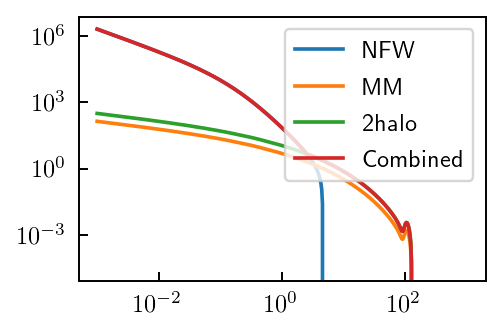

In [33]:
from cluster_toolkit import xi
from cluster_toolkit import bias
#Individual surface density
concentration = 5 #nominal concentration
mass = 1e14
radii = np.logspace(-3,3,500)

#Halo-matter correlation
xi_nfw = xi.xi_nfw_at_R(radii, mass, concentration, Omega_m)
#k and P come from CLASS
xi_mm = xi.xi_mm_at_R(radii, k_ps, Plin)
bias_val = bias.bias_at_M(mass, k_ps, Plin, Omega_m)
xi_2halo = xi.xi_2halo(bias_val, xi_mm)
xi_hm = xi.xi_hm(xi_nfw, xi_2halo)
    
plt.figure(figsize=(3,2))
plt.plot(radii, xi_nfw, label='NFW')
plt.plot(radii, xi_mm, label='MM')
plt.plot(radii, xi_2halo, label='2halo')
plt.plot(radii, xi_hm, label='Combined')
plt.yscale('log'); plt.xscale('log')
plt.legend()
plt.show()

## Define mass, richness, redshift bins and radii spacing

In [34]:
#Bin the DS_stackedd_diff in 15 r_p log bins. 
ds_tplt_file = ds_tplt_dir + 'fit_cauchy_sqr_errorbar.dat'
ds_tplt = np.genfromtxt(ds_tplt_file, unpack=True)
ds_tplt = ds_tplt.reshape(12, 4, 4)

z_min = ds_tplt[0]; z_max = ds_tplt[1]
m_min = ds_tplt[2]; m_max = ds_tplt[3]

cov_num = 15 #Change this to whatever the covariance matrix size is. 
lmda_bins = [[20,30],[30,50],[50,303.0]] #303.0 is highest richness in the sample. 
r_cov = np.logspace(-1,2,cov_num) ##From Heidi: 15 equally log spaced bins from 0.1 to 100 Mpc.

In [35]:
print "Residual of fit (DOF=44) \n", ds_tplt[10]

Residual of fit (DOF=44) 
[[85.203503 25.580346 34.008847 18.551741]
 [65.605008 23.623372 25.566687 28.903263]
 [91.767755 66.490323 48.256955 88.200611]
 [99.745247 71.862994 33.589224 21.297794]]


In [36]:
z_bins = [[0.0, 0.0] for i in range(4)]
for i in range(len(z_bins)):
    z_bins[i][0] = z_min[i][0]; z_bins[i][1] = z_max[i][1]
    
m_bins = [[0.0, 0.0] for i in range(3)] #Note: Discard the lowest mass bin as Cov. matrix does not have that. 
for i in range(len(m_bins)):
    m_bins[i][0] = m_min[0][i+1]; m_bins[i][1] = m_max[1][i+1]
    
print np.asmatrix(z_bins), '\n'
print np.asmatrix(m_bins)

[[0.   0.34]
 [0.34 0.5 ]
 [0.5  0.7 ]
 [0.7  0.9 ]] 

[[1.e+14 2.e+14]
 [2.e+14 4.e+14]
 [4.e+14 1.e+16]]


## Import DS_fracdiff:
Difference between DS_stacked_avg and DS_stacked_cosi.

3-4 record array, first 3 dimensions a different bin in parameter, last dimension the radius, ranging from (-2,2) in np.log(r) (0.01 to 100 Mpc/h). From outer to inner dimension:

Redshift bin: [0, 0.34), [0.34, 0.5), [0.5, 0.7), [0.7, 0.9)

Mass range: [1e14, 2e14), [2e14, 4e14), [4e14, 1e16)

Richness bin: [20, 30), [30, 50), [50, 303.044) (303.044 is highest richness found in sample, proxy for inf. )


In [37]:
import pickle
import copy
filename = homedir + 'output/deltasigma/' + 'DS_stacked_fracdiff.p'
DS_stacked_fracdiff = open(filename, "rb")
DS_stacked_fracdiff = pickle.load(DS_stacked_fracdiff)
print np.shape(DS_stacked_fracdiff)

#Get rid of the lowest mass bin
print "Get rid of lowest mass bin to conform with bins of Cov. matrix. "
DS_stacked_fracdiff = DS_stacked_fracdiff[:,1:,:,:]
print np.shape(DS_stacked_fracdiff)

#Reshuffle the dimensions to be lambda, redshift, mass. 
DS_stacked_newshape = np.empty((3,4,3,50))
for i in range(np.shape(DS_stacked_newshape)[0]):
    DS_stacked_newshape[i] = DS_stacked_fracdiff[:,:,i]
    
DS_stacked_fracdiff = copy.deepcopy(DS_stacked_newshape)
print "Reorder so that bins are in (3,4,3) -- richness, redshift, mass"
print np.shape(DS_stacked_fracdiff)

(4, 4, 3, 50)
Get rid of lowest mass bin to conform with bins of Cov. matrix. 
(4, 3, 3, 50)
Reorder so that bins are in (3,4,3) -- richness, redshift, mass
(3, 4, 3, 50)


#### Sample the 15 r_p

In [38]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

r_num = np.shape(DS_stacked_fracdiff)[-1]
r_fracdiff = np.logspace(-2,2,r_num) #From DS_stacked_fracdiff

r_nearest_ind = []
for i in range(len(r_cov)):
    idx, _ = find_nearest(r_fracdiff, r_cov[i])
    r_nearest_ind.append(idx)

DS_stacked_fracdiff_rp15 = DS_stacked_fracdiff[:,:,:,r_nearest_ind] #(z, M, \lambda, r)

## Import Covariance matrix
Cov with shape + other noise combined. 

(i,j) = (3,3) for 3 z bins and 3 mass bins. 

15 rp from 0.1 to 100 Mph/h

In [90]:
import pickle
cov_file = datadir + 'cov_lensing/DS_cov_binned.p'
infile = open(cov_file,'rb')
cov_data = pickle.load(infile)
infile.close()

#### Plotting the Covariance Matrix

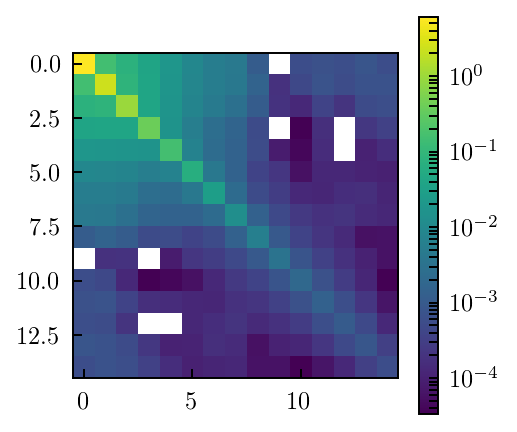

In [91]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(3,3))
plt.imshow(cov_data[0][0], norm=LogNorm())
plt.colorbar()
plt.show()

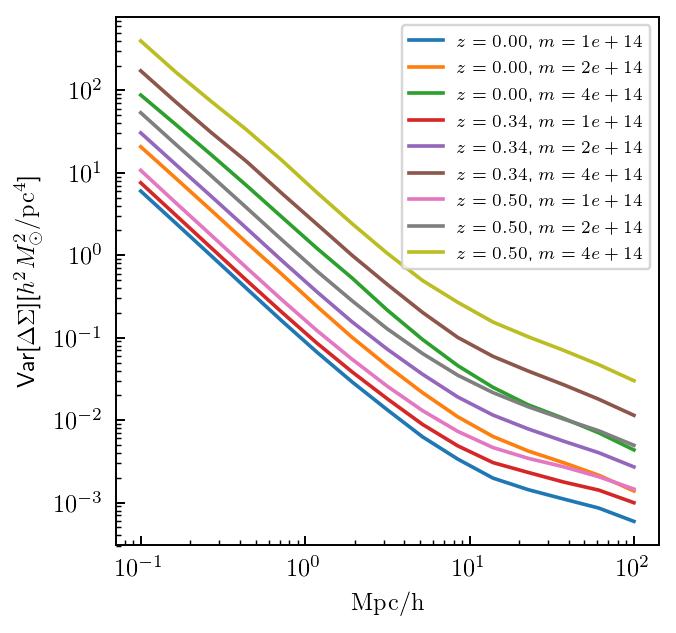

In [92]:
#Plotting it as a function of mass and redshift bins. The diagonal elements. 
r_logbin = np.logspace(-1,2,15)
plt.figure(figsize=(4,4))
for i in range(3):
    for j in range(3):
        diag_elements = np.diagonal(cov_data[i][j])
        plt.plot(r_logbin, diag_elements, label=r'$z={:.2f}$, $m={:.2g}$'.format(z_bins[i][0], m_bins[j][0]))
plt.yscale('log'); plt.xscale('log')
plt.ylabel(r'Var[$\Delta\Sigma$][$h^{2}M^{2}_{\odot}/\rm pc^{4}$]')
plt.xlabel(r'\rm Mpc/h')
plt.legend(fontsize=7)
plt.show()

#### make Covariance matrix (4,3) with Cov. of all redshift bins the same. Only a function of mass

In [93]:
cov_data_mod = np.asarray([[np.zeros((cov_num, cov_num)) for j in range(len(m_bins))] for i in range(len(z_bins))])
print np.shape(cov_data_mod)

for i in range(3):
    cov_data_mod[:,i] = cov_data[0][i] #have same mass bins but use lowest z bins
cov_data = cov_data_mod

(4, 3, 15, 15)


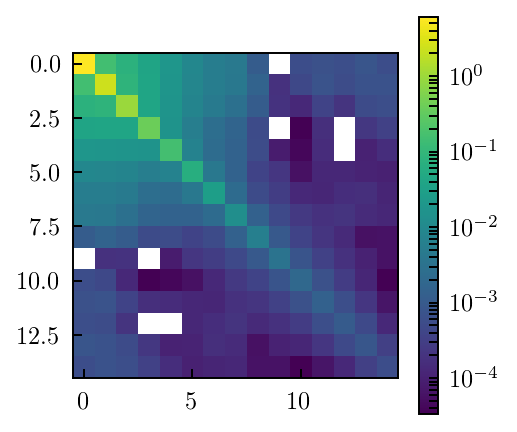

In [94]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(3,3))
plt.imshow(cov_data[2][0], norm=LogNorm())
plt.colorbar()
plt.show()

### Build inverse Cov. matrix for each bin

In [95]:
cov_inv = np.asarray([[np.asarray(np.linalg.inv(cov_data[i][j])) for j in range(3)] for i in range(4) ])

In [96]:
## Test that inv_cov works
#test_identity = [[getMatrixProduct(cov_data[i][j], cov_inv[i][j]) for j in range(3)] for i in range(4)]
#print np.sum(test_identity[2][0]) #Good enough

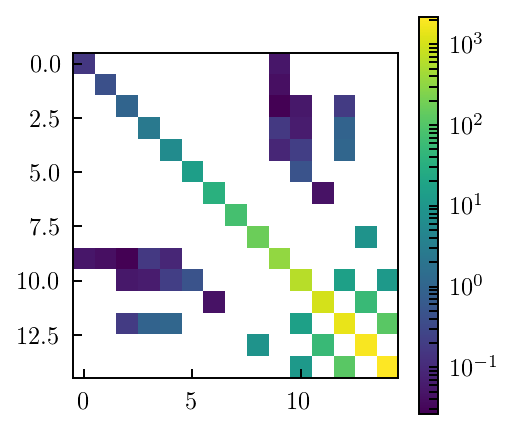

In [97]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(3,3))
plt.imshow(cov_inv[2][0], norm=LogNorm())
plt.colorbar()
plt.show()

##  Build tabulated derivatives for individual $\Delta\Sigma$ as functions of mass and concentration

#### For Testing

In [50]:
from cluster_toolkit import deltasigma
mass = 1e14 #Msun/h
concentration = 5 #arbitrary
r = np.logspace(-2,2.2,200)
#radii = np.logspace(-3,3,500) #radii has to match the radii used for calculating xi_hm
#halo-matter correlation calculated above
Sigma = deltasigma.Sigma_at_R(r, radii, xi_hm, mass, concentration, Omega_m)
DS_bar = deltasigma.DeltaSigma_at_R(r, r, Sigma, mass, concentration, Omega_m)


## Testing cases for individual bins. This part can ignore after testing. 

#### Vary mass at fixed concentration

In [51]:
## Make array of mass and concentration
#Shape of DS_arr is mass_bins, concentration bins, and radial bins
mass = np.linspace(2e14, 1e16, 1000)
concentration = [5] #np.linspace(3,6,10)
r_logbin = np.logspace(-1,2,15) #from 0.1 to 100 Mpc in 15 log bins.

DS_nmass = len(mass)
DS_nconc = len(concentration)
DS_arr = [[0]*DS_nconc for i in range(DS_nmass)]

for i in range(DS_nmass):
    for j in range(DS_nconc):
        Sigma = deltasigma.Sigma_at_R(r_logbin, radii, xi_hm, mass[i], concentration[j], Omega_m)
        DS_arr[i][j] = deltasigma.DeltaSigma_at_R(r_logbin, r_logbin, Sigma, mass[i], concentration[j], Omega_m)

In [52]:
#For derivative with respect to mass only. To make the number larger multiple by a factor, then after inverting Cov.
#to get Fisher matrix divide by that factor again to avoid precision error. 
dDS_mass_multi_factor = 1e15

dDS_arr_mass = np.zeros((DS_nmass-1,15))
for i in range(DS_nmass-1):
    dDS_arr_mass[i,:] = (DS_arr[(i+1)][0][:]-DS_arr[i][0][:])/(mass[i+1]-mass[i]) * dDS_mass_multi_factor #Test!
    
dDS_arr_mass_5e14 = dDS_arr_mass[100,:]
DS_arr_mass_5e14 = DS_arr[31]
print dDS_arr_mass_5e14
print "{:g}".format(mass[31]) #index 31 closest to 5e14

[5.72099025e+02 2.13255273e+02 7.94929017e+01 2.96317241e+01
 1.10455029e+01 4.11731472e+00 1.53476765e+00 5.72099025e-01
 2.13255273e-01 7.94929017e-02 2.96317241e-02 1.10455029e-02
 4.11731472e-03 1.53476765e-03 5.72099025e-04]
5.04104e+14


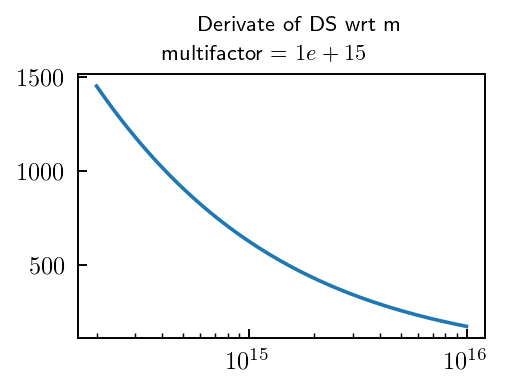

In [53]:
plt.figure(figsize=(3,2))
plt.tight_layout()
#plt.rc('text', usetex=True)
plt.title(r'Derivate of DS wrt m \\ multifactor = ${:.2g}$'.format(dDS_mass_multi_factor), fontsize=9)
plt.plot(mass[0:-1], dDS_arr_mass[:,0])
plt.xscale('log')
plt.show()

#### Vary concentration at fixed mass

In [54]:
## Make array of mass and concentration
#Shape of DS_arr is mass_bins, concentration bins, and radial bins
mass = [5e14]
concentration = np.linspace(3,6,1000)
r_logbin = np.logspace(-1,2,15) #from 0.1 to 100 Mpc in 15 log bins.

DS_nmass = len(mass)
DS_nconc = len(concentration)
DS_arr = [[0]*DS_nconc for i in range(DS_nmass)]

for i in range(DS_nmass):
    for j in range(DS_nconc):
        Sigma = deltasigma.Sigma_at_R(r_logbin, radii, xi_hm, mass[i], concentration[j], Omega_m)
        DS_arr[i][j] = deltasigma.DeltaSigma_at_R(r_logbin, r_logbin, Sigma, mass[i], concentration[j], Omega_m)

In [55]:
#For derivative with respect to mass only
dDS_arr_conc = np.zeros((DS_nconc-1,15))
for i in range(DS_nconc-1):
    dDS_arr_conc[i,:] = (DS_arr[0][i+1][:]-DS_arr[0][i][:])/(concentration[i+1]-concentration[i])
    
dDS_arr_conc_5 = dDS_arr_conc[666,:] ###TEST: Change to something else for now. 
print dDS_arr_conc_5
print "{:g}".format(concentration[666]) #index 666 closest to 5

[1.29187168e+02 4.81557275e+01 1.79504987e+01 6.69121664e+00
 2.49421371e+00 9.29741537e-01 3.46569871e-01 1.29187168e-01
 4.81557275e-02 1.79504987e-02 6.69121664e-03 2.49421371e-03
 9.29741537e-04 3.46569871e-04 1.29187168e-04]
5


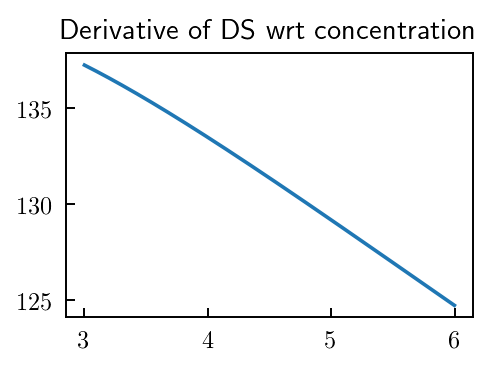

In [56]:
plt.figure(figsize=(3,2))
plt.title('Derivative of DS wrt concentration')
plt.plot(concentration[0:-1], dDS_arr_conc[:,0])
plt.show()

## Estimate mass bias
First test this with individual DS. 

Set $\delta\Delta\Sigma$ uniformly to $2\%$ for now. 

### Inverting covariance matrix

In [57]:
cov_inv = np.linalg.inv(cov_data[1][1]) #For now choose one of the bins

#### Plotting and testing

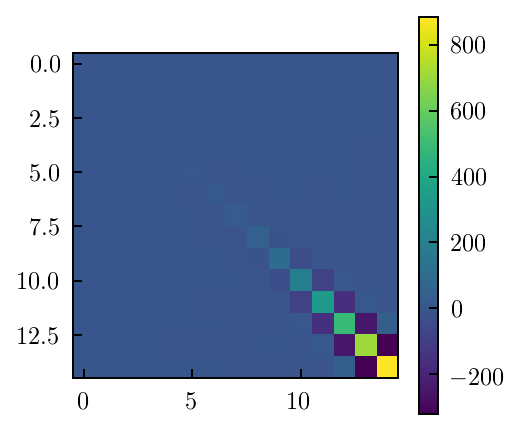

In [58]:
plt.figure(figsize=(3,3))
plt.imshow(cov_inv)
plt.colorbar()
plt.show()

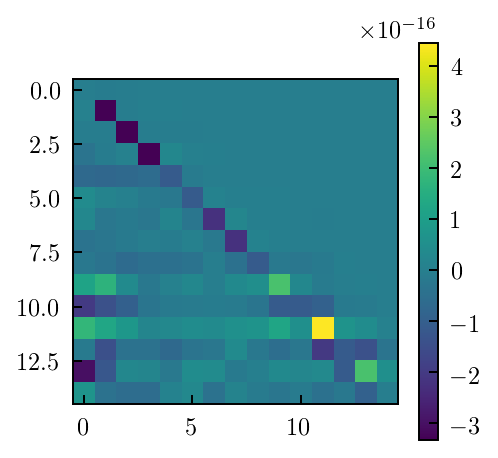

In [59]:
## Test if inv works correctly. 
#The difference is order 10^(16) precision error so pass!
test_identity = np.matmul(cov_inv, cov_data[1][1])
identity = np.eye(15)
test_null = test_identity - identity
plt.figure(figsize=(3,3))
plt.imshow(test_null)
plt.colorbar()
plt.show()

### Build Fisher matrix with inverse_cov and DS derivative 
Set mass to be at m=5e14 for mass derivative.
Set concentration to be c=5 for concentration derivative

In [60]:
def transposeMatrix(m):
    return map(list,zip(*m))

def getMatrixMinor(m,i,j):
    return [row[:j] + row[j+1:] for row in (m[:i]+m[i+1:])]

def getMatrixDeterminant(m):
    #base case for 2x2 matrix
    if len(m) == 2:
        return m[0][0]*m[1][1]-m[0][1]*m[1][0]

    determinant = 0
    for c in range(len(m)):
        determinant += ((-1)**c)*m[0][c]*getMatrixDeternminant(getMatrixMinor(m,0,c))
    return determinant

def getMatrixInverse(m):
    determinant = getMatrixDeterminant(m)
    #special case for 2x2 matrix:
    if len(m) == 2:
        return [[m[1][1]/determinant, -1*m[0][1]/determinant],
                [-1*m[1][0]/determinant, m[0][0]/determinant]]

    #find matrix of cofactors
    cofactors = []
    for r in range(len(m)):
        cofactorRow = []
        for c in range(len(m)):
            minor = getMatrixMinor(m,r,c)
            cofactorRow.append(((-1)**(r+c)) * getMatrixDeterminant(minor))
        cofactors.append(cofactorRow)
    cofactors = transposeMatrix(cofactors)
    for r in range(len(cofactors)):
        for c in range(len(cofactors)):
            cofactors[r][c] = cofactors[r][c]/determinant
    return cofactors

def getMatrixProduct(m,n):
    return np.sum(m[...,np.newaxis]*n[np.newaxis,...],axis=1)

In [61]:
smoothing_const = 1
deriv_vector = [dDS_arr_mass_5e14 + smoothing_const, dDS_arr_conc_5]
fisher_size = np.shape(deriv_vector)[0]
fisher_mat = np.zeros((2,2))

for i in range(fisher_size):
    for j in range(fisher_size):
        fisher_mat[i,j] = np.linalg.multi_dot([deriv_vector[i], cov_inv, deriv_vector[j]])
fisher_mat = np.asarray(fisher_mat)
print "Fisher matrix \n", fisher_mat

Fisher matrix 
[[21991.02455738  4704.97272429]
 [ 4704.97272429  1061.56689737]]


### Get mass bias from Fisher matrix, DS_diff

In [62]:
fisher_inv = getMatrixInverse(np.asarray(fisher_mat)) #Use costume function to get Inverse for better accuracy
fisher_inv = np.asarray(fisher_inv)
print "Fisher inverse \n", fisher_inv
print "This should be I(2) after smoothing \n",np.dot(fisher_mat, fisher_inv) #This does not work for some reason. Gives rounding errors?
print "This matrix should be I(2): \n", getMatrixProduct(fisher_mat, fisher_inv) #Custom function to calculate matrix product. 


Fisher inverse 
[[ 0.00087865 -0.00389428]
 [-0.00389428  0.01820185]]
This should be I(2) after smoothing 
[[1.00000000e+00 1.20680254e-14]
 [3.71317843e-16 1.00000000e+00]]
This matrix should be I(2): 
[[1.00000000e+00 1.42108547e-14]
 [0.00000000e+00 1.00000000e+00]]


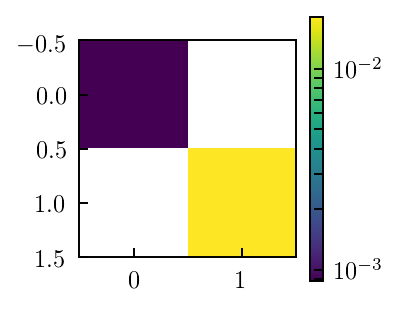

In [63]:
## Covariance matrix between mass and concentration
from matplotlib.colors import LogNorm
plt.figure(figsize=(2,2))
plt.imshow(fisher_inv, norm=LogNorm())
plt.colorbar()
plt.show()

### Testing mass bias with fiducial mass bias 

### Mass bias from frac_diff between orientation/non-orienation bias

In [64]:
p=0; q=1; i=0; j=0; k=0
print fisher_inv[0,p] * np.linalg.multi_dot([DS_stacked_fracdiff_rp15[i,j,k], cov_inv, deriv_vector[p]])
print fisher_inv[0,q] * np.linalg.multi_dot([DS_stacked_fracdiff_rp15[i,j,k], cov_inv, deriv_vector[q]])

0.08213287184352198
-0.004213271692733186


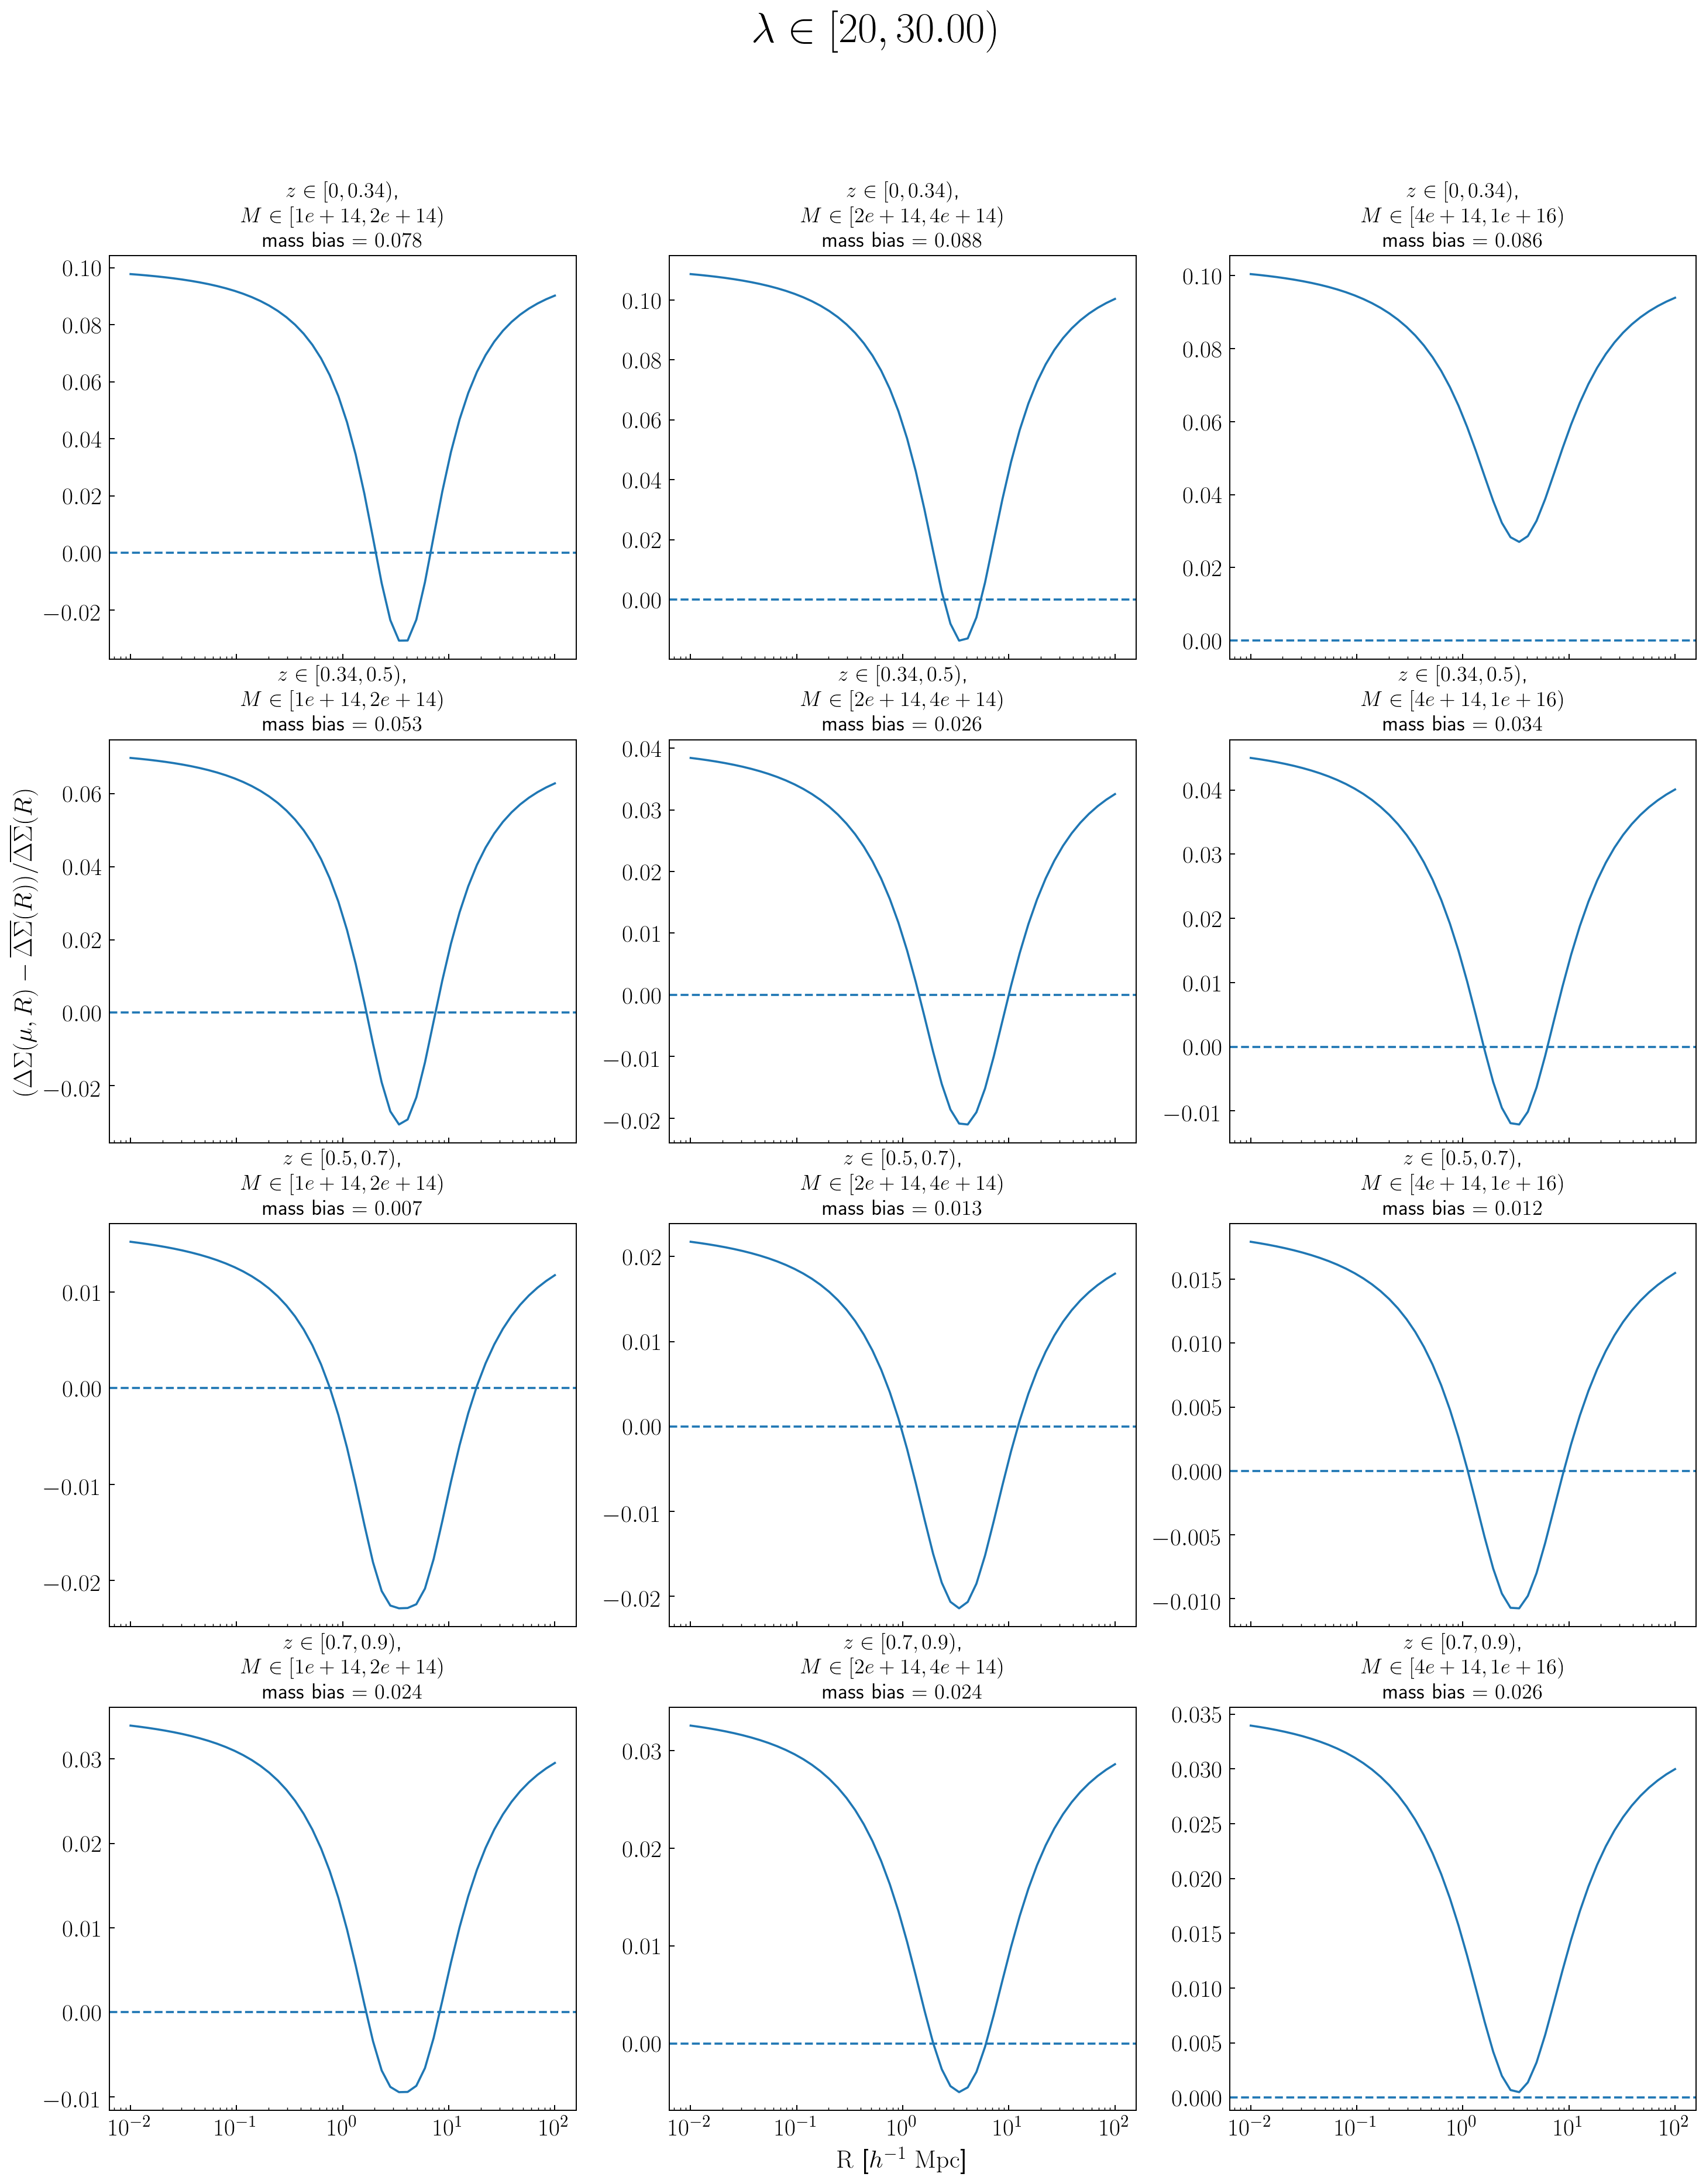

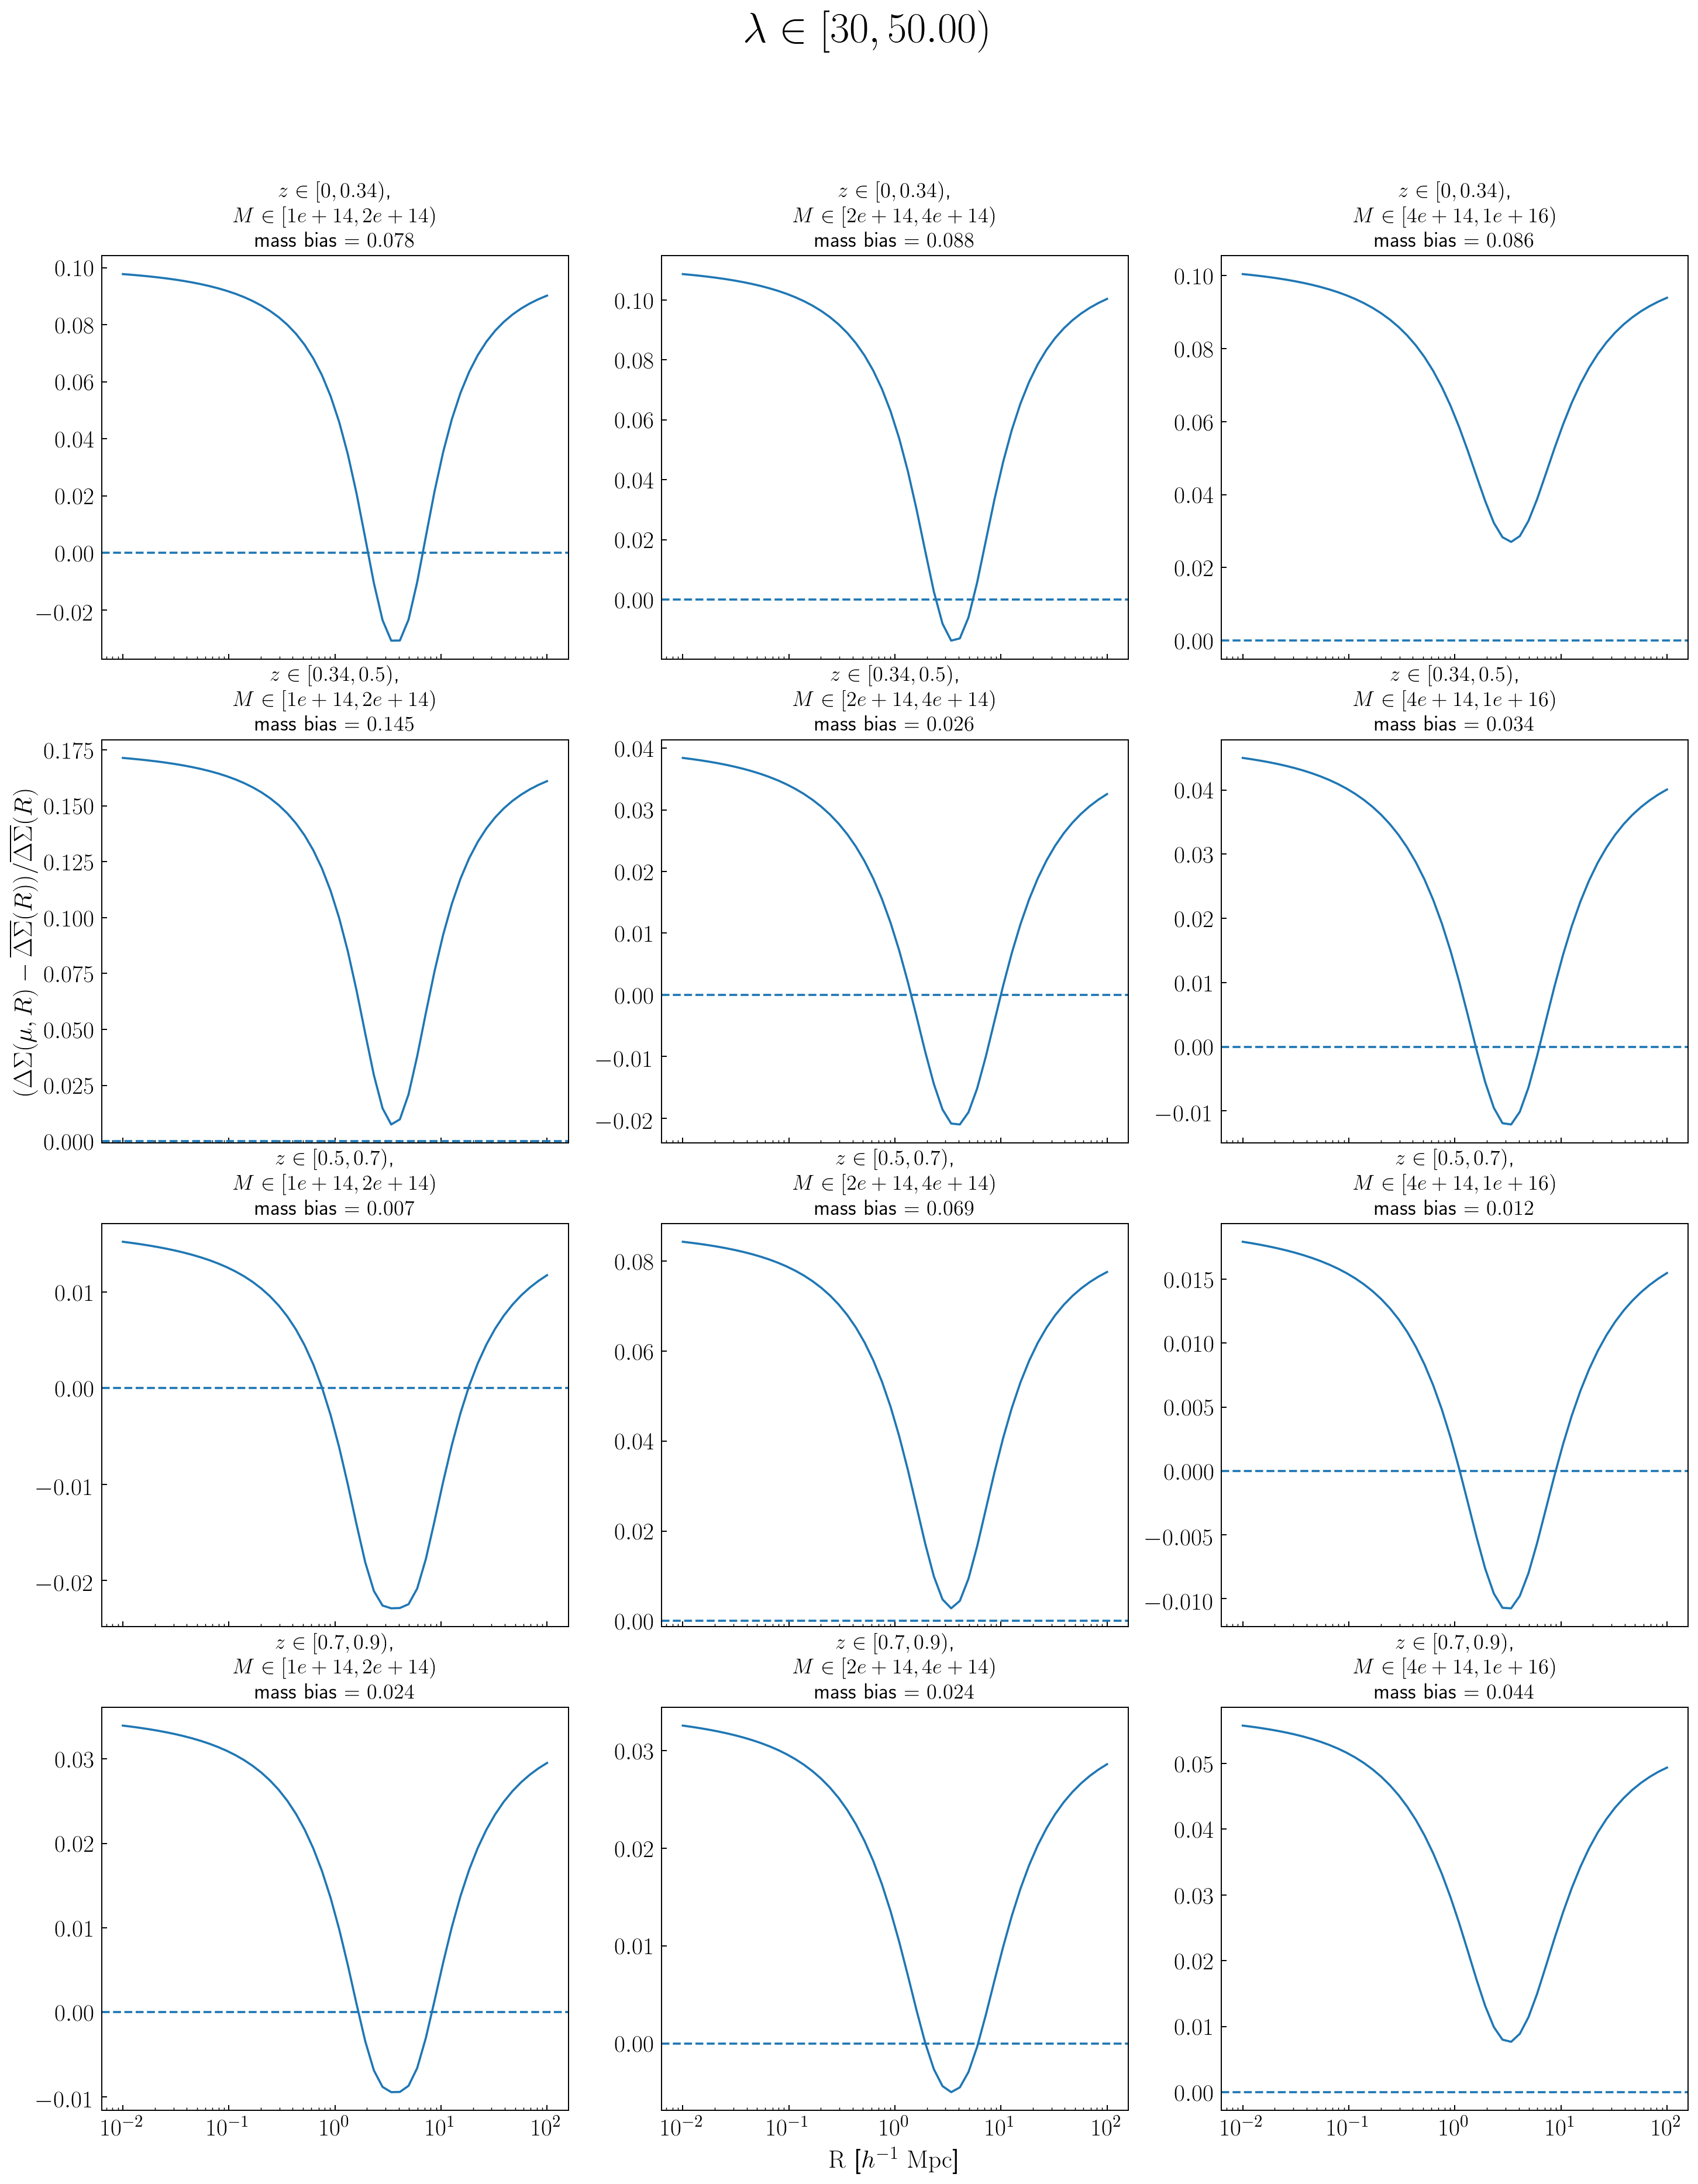

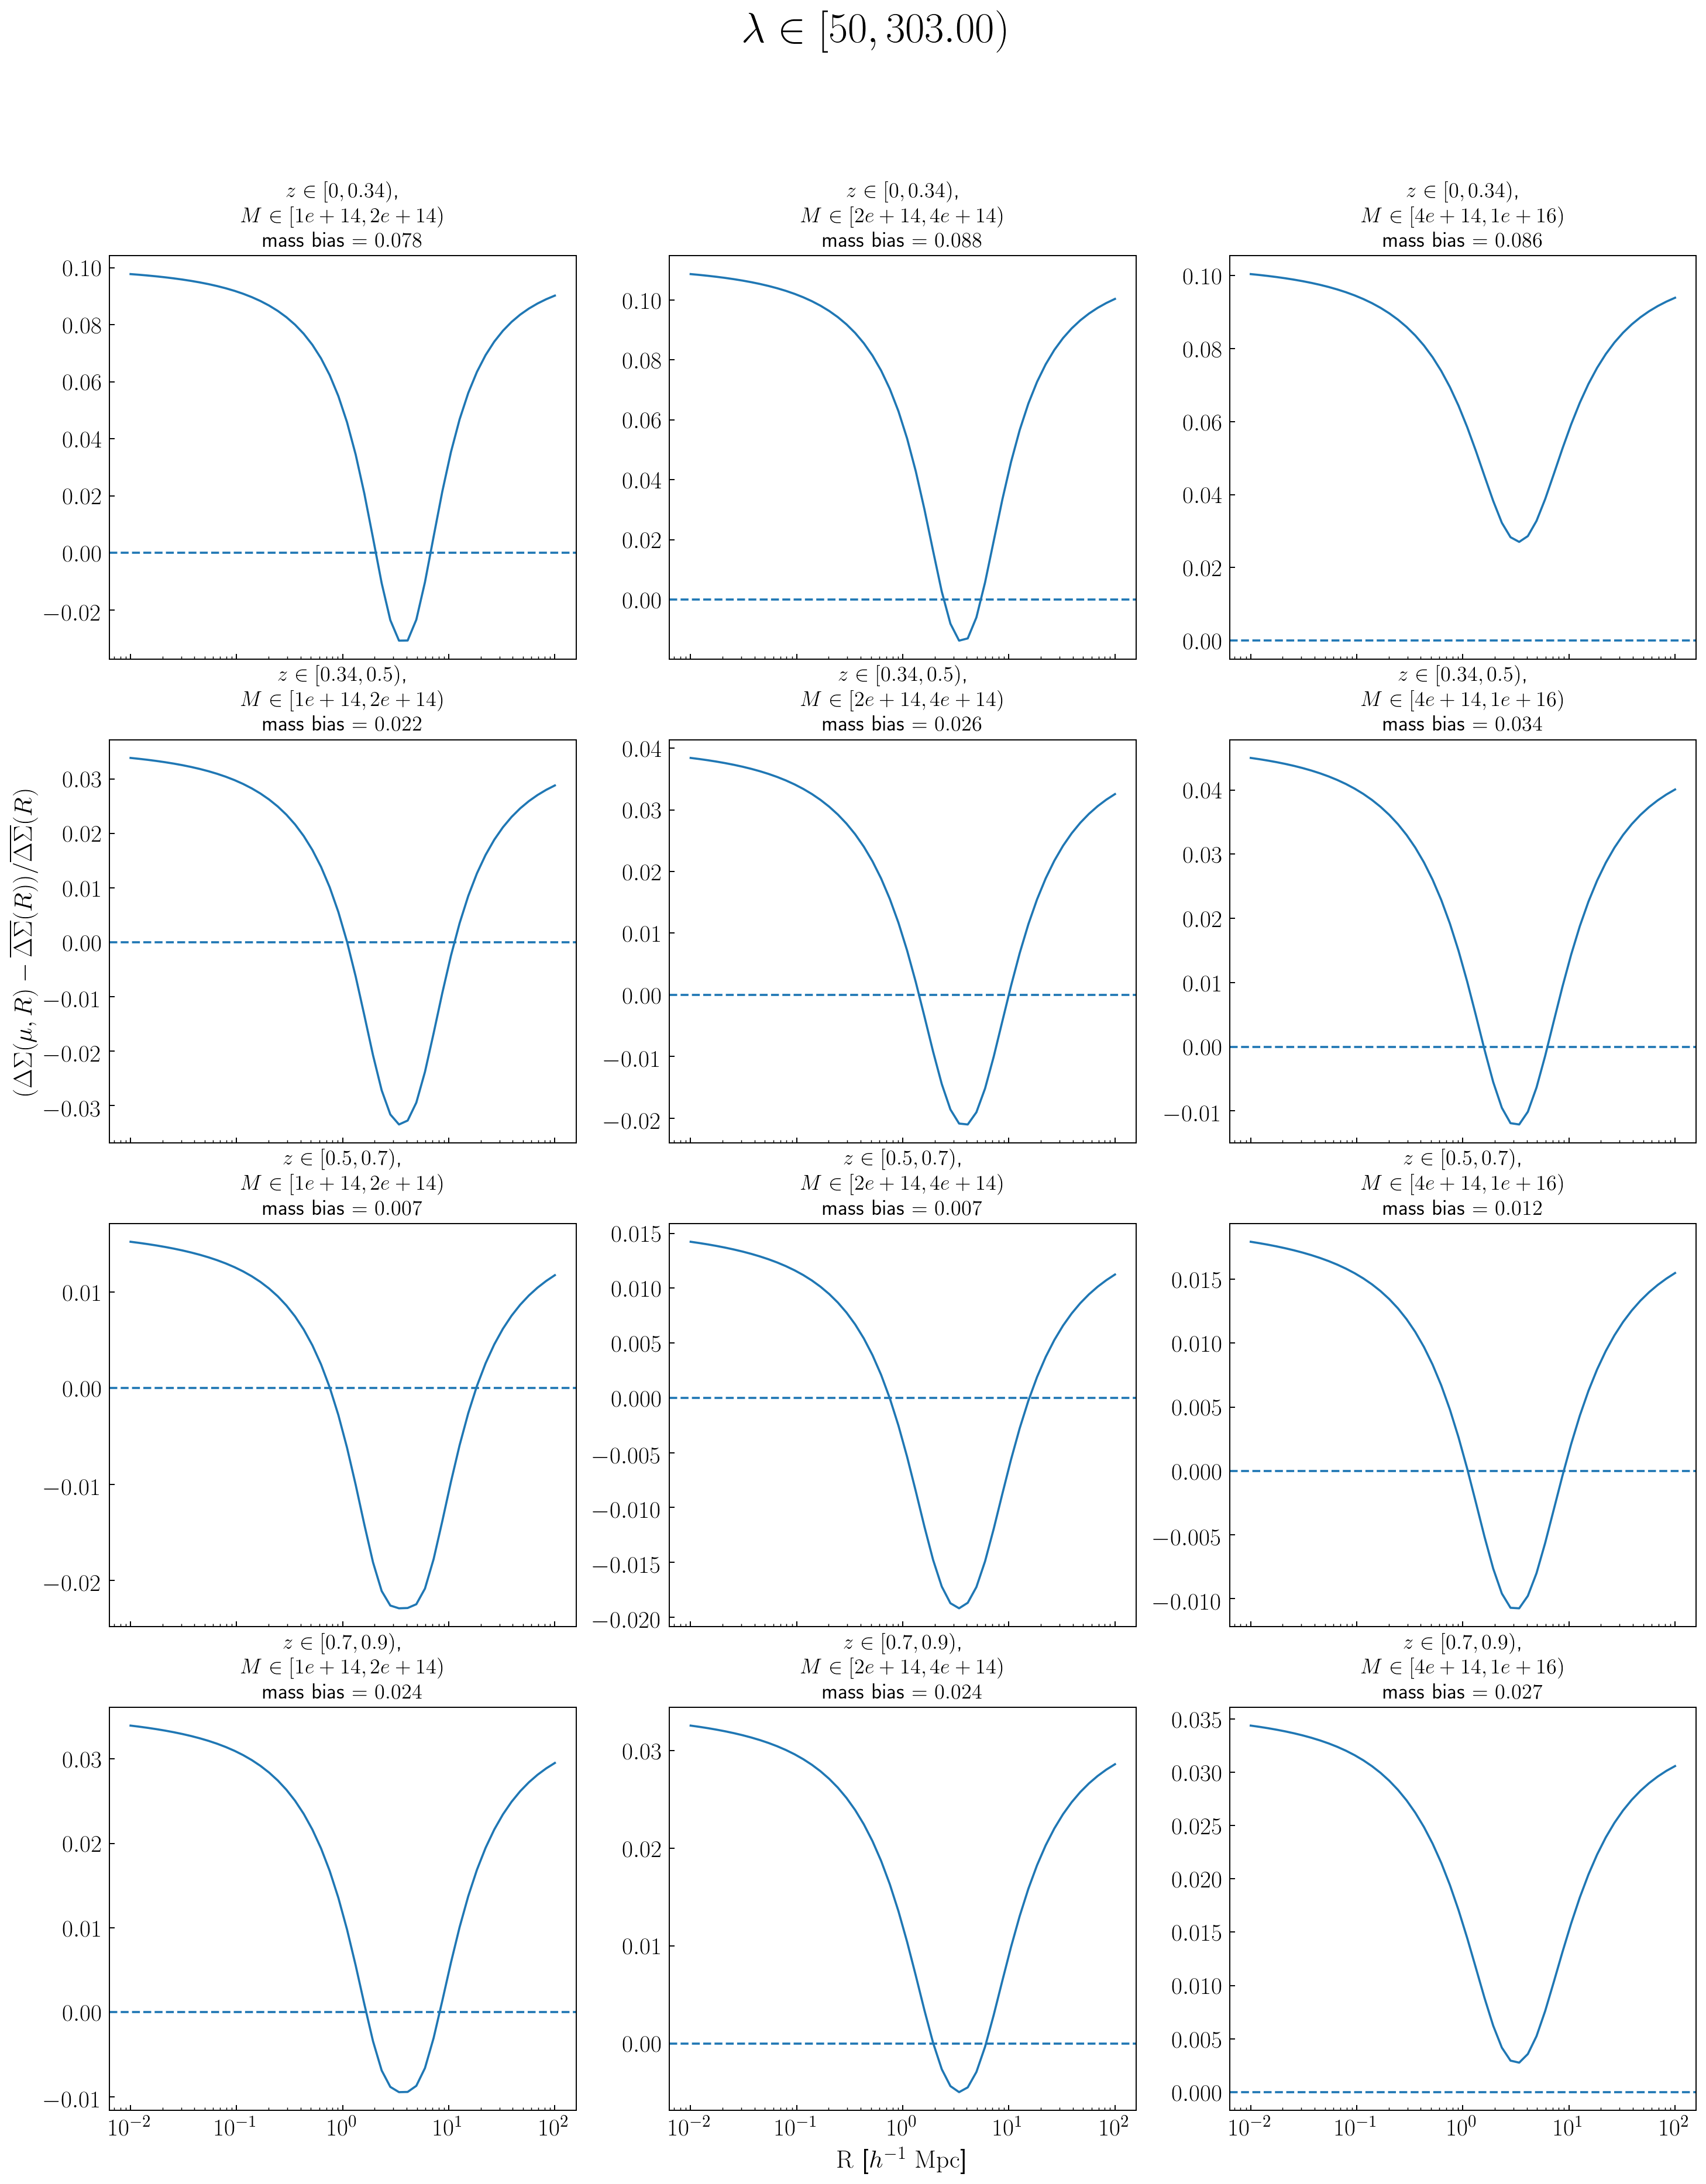

In [65]:
#Plot all and see what the difference is. Are all above 0.0 or any below 0.0. Can we disregard any based on noise?
for i in range(len(lmda_bins)):
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,24), sharex='all')
    fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[i][0],lmda_bins[i][1]), fontsize=30)
    for j, z_cur in enumerate(np.asarray(z_bins)[:,0]):
           #print "\nredshift range is [{0:.2g}, {1:.2g})".format(z_min[p,0], z_max[p,0])

        for k, m_cur in enumerate(np.asarray(m_bins)[:,0]):
            #print "mass range is [{0:.2g}, {1:.2g})".format(m_min[0,q], m_max[0,q])
            mass_bias = 0.
            for p in range(2): #j to conform with notation on notes
                mass_bias += fisher_inv[0,p] * np.linalg.multi_dot([DS_stacked_fracdiff_rp15[i,j,k], cov_inv, deriv_vector[p]])
                mass_bias = float(mass_bias)

            ax[j,k].plot(r_fracdiff, DS_stacked_fracdiff[i,j,k]) #Not the downsampled fracfiff
            ax[j,k].tick_params(axis='both', which='major', labelsize=17)
            ax[j,k].set_title('$z \in [{0:.2g}, {1:.2g})$, \n $M \in [{2:.2g}, {3:.2g})$ \n mass bias = ${4:.3f}$'\
                              .format(z_bins[j][0], z_bins[j][1], m_bins[k][0], m_bins[k][1], mass_bias), fontsize=15)
            ax[j,k].axhline(0.0, linestyle='--')

            
    ax[1,0].set_xscale('log'); #axs[1].set_yscale('log')
    ax[1,0].set_ylabel(r"$\big(\Delta\Sigma(\mu, R)-\overline{\Delta\Sigma}(R)\big)/\overline{\Delta\Sigma}(R)$", fontsize=18)
    ax[3,1].set_xlabel(r"\textrm{R} [$h^{-1}~$\textrm{Mpc}]"  , fontsize=18)
    plt.show()
#ax[0,0].legend(loc='upper left', fontsize=19)


## Calculating the mass-bias in richness-bins, marginalized over mass and redshift. 

### Get P(M, Z | \lambda bin) from red-matched halos

In [78]:
import pickle

redM_halos = homedir + 'output/buzzard/redM_halos_fullmatchingparams_matchingv1.2_Buzzardv1.6.data'

infile = open(redM_halos,'rb')
redM_halos = pickle.load(infile)
infile.close()

redM_halos = redM_halos.view(np.recarray)
print redM_halos.dtype
print len(redM_halos)

(numpy.record, [('GALAXY_ID', '>i4'), ('HALOID', '>i4'), ('DESCID', '>i8'), ('RA_OBS', '>f8'), ('DEC_OBS', '>f8'), ('TRA', '>f8'), ('TDEC', '>f8'), ('Z', '>f8'), ('MVIR', '>f8'), ('VMAX', '>f8'), ('VRMS', '>f8'), ('RVIR', '>f8'), ('RS', '>f8'), ('NP', '>f8'), ('PX', '>f8'), ('PY', '>f8'), ('PZ', '>f8'), ('VX', '>f8'), ('VY', '>f8'), ('VZ', '>f8'), ('JX', '>f8'), ('JY', '>f8'), ('JZ', '>f8'), ('SPIN', '>f8'), ('RS_KLYPIN', '>f8'), ('MVIR_ALL', '>f8'), ('M200B', '>f8'), ('M200C', '>f8'), ('M500C', '>f8'), ('M2500C', '>f8'), ('XOFF', '>f8'), ('VOFF', '>f8'), ('SPIN_BULLOCK', '>f8'), ('B_TO_A', '>f8'), ('C_TO_A', '>f8'), ('PID', '>i8'), ('LUMTOT', '>f8'), ('LUM20', '>f8'), ('LBCG', '>f8'), ('NGALS', '>i8'), ('N18', '>i8'), ('N19', '>i8'), ('N20', '>i8'), ('N21', '>i8'), ('N22', '>i8'), ('matching_ID', '<i8'), ('MEM_MATCH_ID', '<i8'), ('LAMBDA_CHISQ', '<f8'), ('RA_REDM', '<f8'), ('DEC_REDM', '<f8'), ('q', '<f8'), ('s', '<f8'), ('cosi', '<f8'), ('centered_flag', '<i8')])
13628


### Apply mass and redshift cuts to ensure fullness of richness-selected clusters. 
By that I mean applying cuts to have all clusters fit into the redshift and mass bins.

In [79]:
print "z_max, m_max, m_min"
print z_max[-1][-1], m_max[-1][-1], "{:.2g}".format(m_bins[0][0]) #From Heidi's templates
print "Before mass cut number is ", len(redM_halos)
redM_halos = redM_halos[np.where((redM_halos.M200B >= m_bins[0][0]) & (redM_halos.M200B <= m_bins[-1][-1]))]
print "Before mass cut number is ", len(redM_halos)

print "Before z cut number is ", len(redM_halos)
redM_halos = redM_halos[np.where(redM_halos.Z <= z_max[-1][-1])]
print "Before z cut number is ", len(redM_halos)

z_max, m_max, m_min
0.9 1e+16 1e+14
Before mass cut number is  13628
Before mass cut number is  8802
Before z cut number is  8802
Before z cut number is  8802


### Bins halos mass, redshift and richness. 
(3,4,3) bin sizes for richness, redshift, mass.
prob_binned gives the probability of occuring in mass and redshift bin in each richness bin. 

In [80]:
from __future__ import division #Python 3 float divide
prob_binned = np.empty((3,4,3)) #Binned in richness, redshift, mass.

In [81]:
for i in range(np.shape(prob_binned)[0]): #lambda bins
    lmda_bin_ind = np.where((redM_halos.LAMBDA_CHISQ > lmda_bins[i][0]) & \
                                (redM_halos.LAMBDA_CHISQ < lmda_bins[i][1]))
    num_lmda_bin = len(lmda_bin_ind[0])
    redM_halos_lmda_binned = redM_halos[lmda_bin_ind]
    
    for j in range(np.shape(prob_binned)[1]): #redshift bins
        z_bin_ind = np.where((redM_halos_lmda_binned.Z > z_bins[j][0]) & \
                                    (redM_halos_lmda_binned.Z < z_bins[j][1]))
        redM_halos_z_binned = redM_halos_lmda_binned[z_bin_ind]
        
        for k in range(np.shape(prob_binned)[2]): #mass bins
            m_bin_ind = np.where((redM_halos_z_binned.M200B > m_bins[k][0]) & \
                                    (redM_halos_z_binned.M200B < m_bins[k][1]))
            redM_halos_m_binned = redM_halos_z_binned[m_bin_ind]
            
            #Calc prob
            prob_bin = len(redM_halos_m_binned)/num_lmda_bin #Float divide
            prob_binned[i,j,k] = prob_bin
            
            
print prob_binned
print np.sum(prob_binned[0]), np.sum(prob_binned[1]), np.sum(prob_binned[2])

[[[7.59451322e-02 5.75443292e-02 1.97390432e-02]
  [3.13482770e-01 8.46436935e-02 2.34192037e-03]
  [4.07159585e-01 3.78052860e-02 0.00000000e+00]
  [1.33824021e-03 0.00000000e+00 0.00000000e+00]]

 [[2.49791840e-02 3.91340550e-02 2.02608937e-02]
  [2.05939495e-01 1.51817930e-01 1.47099639e-02]
  [4.04385235e-01 1.35442687e-01 1.94282542e-03]
  [1.11018596e-03 2.77546489e-04 0.00000000e+00]]

 [[4.53103761e-03 1.04213865e-02 2.80924332e-02]
  [6.75124604e-02 1.64929769e-01 1.06479384e-01]
  [1.94834617e-01 3.22156774e-01 9.83235161e-02]
  [1.81241504e-03 4.53103761e-04 4.53103761e-04]]]
1.0 1.0 1.0


## Calculate the Fisher matrix for each mass and redshift bin

### Calculate the mass and concentration derivate at representative location in each bin. 

#### Analytic fit of c(M,z)

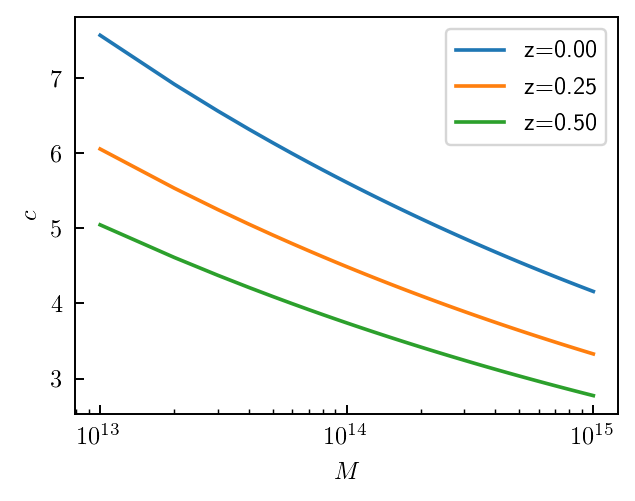

In [82]:
#From Mandelbaum et al. 2008
def concentration(M, z):
    beta = 0.13
    c_0 = 5.612 #4.6 for z=1.22 so 4.6*(1+0.22) for z=0
    M_0 = 1e14 #Msun/h
    return c_0/(1+z)*(M/M_0)**(-beta)

M = np.linspace(1e13, 1e15, 100)
z_arr = np.linspace(0.0, 0.5, 3)
plt.figure(figsize=(4,3))
for i in range(3):
    z = z_arr[i] 
    c = concentration(M,z)
    plt.plot(M, c, label='z={:.2f}'.format(z))
plt.legend()
plt.xscale('log')
plt.ylabel(r'$c$'); plt.xlabel(r'$M$')
plt.show()

#### Derivative of mass at fixed c and z
dDS_mass_bin shape of (4, 3, 15) for bins in redshift, mass and radii. 

In [83]:
#Calculate the derivate at mean in mass bin given the concentration(M,z)
dDS_mass_multi_factor = 1e15
dDS_mass_bin = np.asarray([[np.zeros(cov_num) for j in range(3)] for i in range(4)])
mass = np.linspace(1e14, 1e16, 1000)
for i, z_bin in enumerate(z_bins):
    for j, m_bin in enumerate(m_bins):
        #z_mean, m_mean, c_bin, and r_logbin 
        z_mean = np.mean(z_bin); m_mean = np.mean(m_bin)
        c_bin = concentration(m_mean, z_mean)
        print "z_mean={:.2f}, m_mean={:.2g}, c_mean={:.2f}".format(z_mean, m_mean, c_bin)
        r_logbin = np.logspace(-1,2,cov_num) #from 0.1 to 100 Mpc in 15 log bins.
        DS_nmass = len(mass)
        DS_arr = [[0] for k in range(DS_nmass)]

        #Build semi-analytic DS profiles with varying mass
        for k in range(DS_nmass):
                Sigma = deltasigma.Sigma_at_R(r_logbin, radii, xi_hm, mass[k], c_bin, Omega_m)
                DS_arr[k] = deltasigma.DeltaSigma_at_R(r_logbin, r_logbin, Sigma, mass[k], c_bin, Omega_m)
        
        #Calculate first order derivative
        dDS_arr_mass = np.zeros((DS_nmass-1,cov_num))
        for k in range(DS_nmass-1):
            dDS_arr_mass[k,:] = (DS_arr[(k+1)][:]-DS_arr[k][:])/(mass[k+1]-mass[k]) * dDS_mass_multi_factor

        #Find derivate closest to m_mean
        idx_m_mean = (np.abs(mass - m_mean)).argmin()
        dDS_mass_bin[i,j] = dDS_arr_mass[idx_m_mean]
        #print "nearest mass to m_mean is {:.2g}".format(mass[idx_m_mean])


z_mean=0.17, m_mean=1.5e+14, c_mean=4.55
z_mean=0.17, m_mean=3e+14, c_mean=4.16
z_mean=0.17, m_mean=5.2e+15, c_mean=2.87
z_mean=0.42, m_mean=1.5e+14, c_mean=3.75
z_mean=0.42, m_mean=3e+14, c_mean=3.43
z_mean=0.42, m_mean=5.2e+15, c_mean=2.36
z_mean=0.60, m_mean=1.5e+14, c_mean=3.33
z_mean=0.60, m_mean=3e+14, c_mean=3.04
z_mean=0.60, m_mean=5.2e+15, c_mean=2.10
z_mean=0.80, m_mean=1.5e+14, c_mean=2.96
z_mean=0.80, m_mean=3e+14, c_mean=2.70
z_mean=0.80, m_mean=5.2e+15, c_mean=1.87


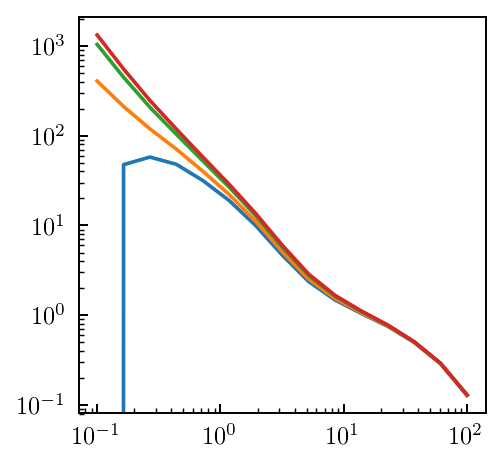

In [84]:
#Plotting DS for different masses. Derivative is first order difference over mass difference
plt.figure(figsize=(3,3))
plt.plot(r_logbin, DS_arr[0])
plt.plot(r_logbin, DS_arr[100])
plt.plot(r_logbin, DS_arr[500])
plt.plot(r_logbin, DS_arr[800])
plt.xscale('log'); plt.yscale('log')

In [85]:
print dDS_mass_bin[:,:,-1] #for all mass and redshift bins in lowest radii of 0.1 Mpc

[[0.00155482 0.00101711 0.00015175]
 [0.00133817 0.0008709  0.00012962]
 [0.00122294 0.00079405 0.00011827]
 [0.0011215  0.00072692 0.00010851]]


#### Derivative of c at fixed M and z
dDS_c_bin shape of (4, 3, 15) for bins in redshift, mass and radii. 

In [86]:
#Calculate the derivate at mean in mass bin given the concentration(M,z)
dDS_c_bin = np.asarray([[np.zeros(cov_num) for j in range(3)] for i in range(4)])
c_arr = np.linspace(1, 7, 1000)
for i, z_bin in enumerate(z_bins):
    for j, m_bin in enumerate(m_bins):
        #z_mean, m_mean, c_bin, and r_logbin 
        z_mean = np.mean(z_bin); m_mean = np.mean(m_bin)      
        c_bin_mean = concentration(m_mean, z_mean)
        print "z_mean={:.2f}, m_mean={:.2g}, c_mean={:.2f}".format(z_mean, m_mean, c_bin_mean)
        r_logbin = np.logspace(-1,2,cov_num) #from 0.1 to 100 Mpc in 15 log bins.
        DS_nc = len(c_arr)
        DS_arr = [[0] for k in range(DS_nc)]

        #Build semi-analytic DS profiles with varying mass
        for k in range(DS_nc):
                Sigma = deltasigma.Sigma_at_R(r_logbin, radii, xi_hm, m_mean, c_arr[k], Omega_m)
                DS_arr[k] = deltasigma.DeltaSigma_at_R(r_logbin, r_logbin, Sigma, m_mean, c_arr[k], Omega_m)
        
        #Calculate first order derivative
        dDS_arr_c = np.zeros((DS_nc-1,cov_num))
        for k in range(DS_nc-1):
            dDS_arr_c[k,:] = (DS_arr[(k+1)][:]-DS_arr[k][:])/(c_arr[k+1]-c_arr[k])

        #Find derivate closest to m_mean
        idx_c_mean = (np.abs(c_arr - c_bin_mean)).argmin()
        dDS_c_bin[i,j] = dDS_arr_c[idx_c_mean]
        #print "nearest mass to m_mean is {:.2g}".format(mass[idx_m_mean])

z_mean=0.17, m_mean=1.5e+14, c_mean=4.55
z_mean=0.17, m_mean=3e+14, c_mean=4.16
z_mean=0.17, m_mean=5.2e+15, c_mean=2.87
z_mean=0.42, m_mean=1.5e+14, c_mean=3.75
z_mean=0.42, m_mean=3e+14, c_mean=3.43
z_mean=0.42, m_mean=5.2e+15, c_mean=2.36
z_mean=0.60, m_mean=1.5e+14, c_mean=3.33
z_mean=0.60, m_mean=3e+14, c_mean=3.04
z_mean=0.60, m_mean=5.2e+15, c_mean=2.10
z_mean=0.80, m_mean=1.5e+14, c_mean=2.96
z_mean=0.80, m_mean=3e+14, c_mean=2.70
z_mean=0.80, m_mean=5.2e+15, c_mean=1.87


In [87]:
print dDS_c_bin[:,:,0]

[[ 61.27536873  97.5103893  469.87580816]
 [ 64.37365595 100.58236228 462.73836923]
 [ 66.03316305 102.10912888 457.94784509]
 [ 67.4917926  103.34782657 452.86234088]]


#### Calculation of Fisher and inverse in all bins. 

In [98]:
#Apply a smoothing scalar to prevent the determinant from being so close to 0.
smoothing_const = 1
deriv_vector = np.asarray([dDS_mass_bin+smoothing_const, dDS_c_bin]) 
fisher_size = np.shape(deriv_vector)[0]
fisher_mat = np.asarray([[np.zeros((fisher_size, fisher_size)) for j in range(3)] for i in range(4)]) #(4,3) for z, m

for i in range(len(z_bins)):
    for j in range(len(m_bins)):
        fisher_mat[i,j] = [[np.linalg.multi_dot([deriv_vector[l,i,j], cov_inv[i,j], deriv_vector[k,i,j]]) \
                                 for l in range(fisher_size)] for k in range(fisher_size)]

print "Check that determinants of Fisher matrix are all positive"
print fisher_mat[0,0]
print np.linalg.det(fisher_mat)
fisher_inv = np.linalg.inv(fisher_mat)

Check that determinants of Fisher matrix are all positive
[[566907.7186116   22238.03927841]
 [ 22238.03927841    876.67460549]]
[[2463209.613967    688324.14843603 1081774.41678967]
 [2718603.38562675  732377.32215639 1049159.59922332]
 [2860577.41938764  754779.97205655 1027549.07968832]
 [2988349.78999414  773203.69533279 1004853.96236431]]


In [99]:
#After smoothing factor np.dot(fisher_mat, fisher_inv) should give identity.
test_identity = np.dot(fisher_mat[1,1], fisher_inv[1,1])
print test_identity

[[ 1.00000000e+00  7.20615667e-15]
 [-2.48906247e-16  1.00000000e+00]]


### Test individual bins


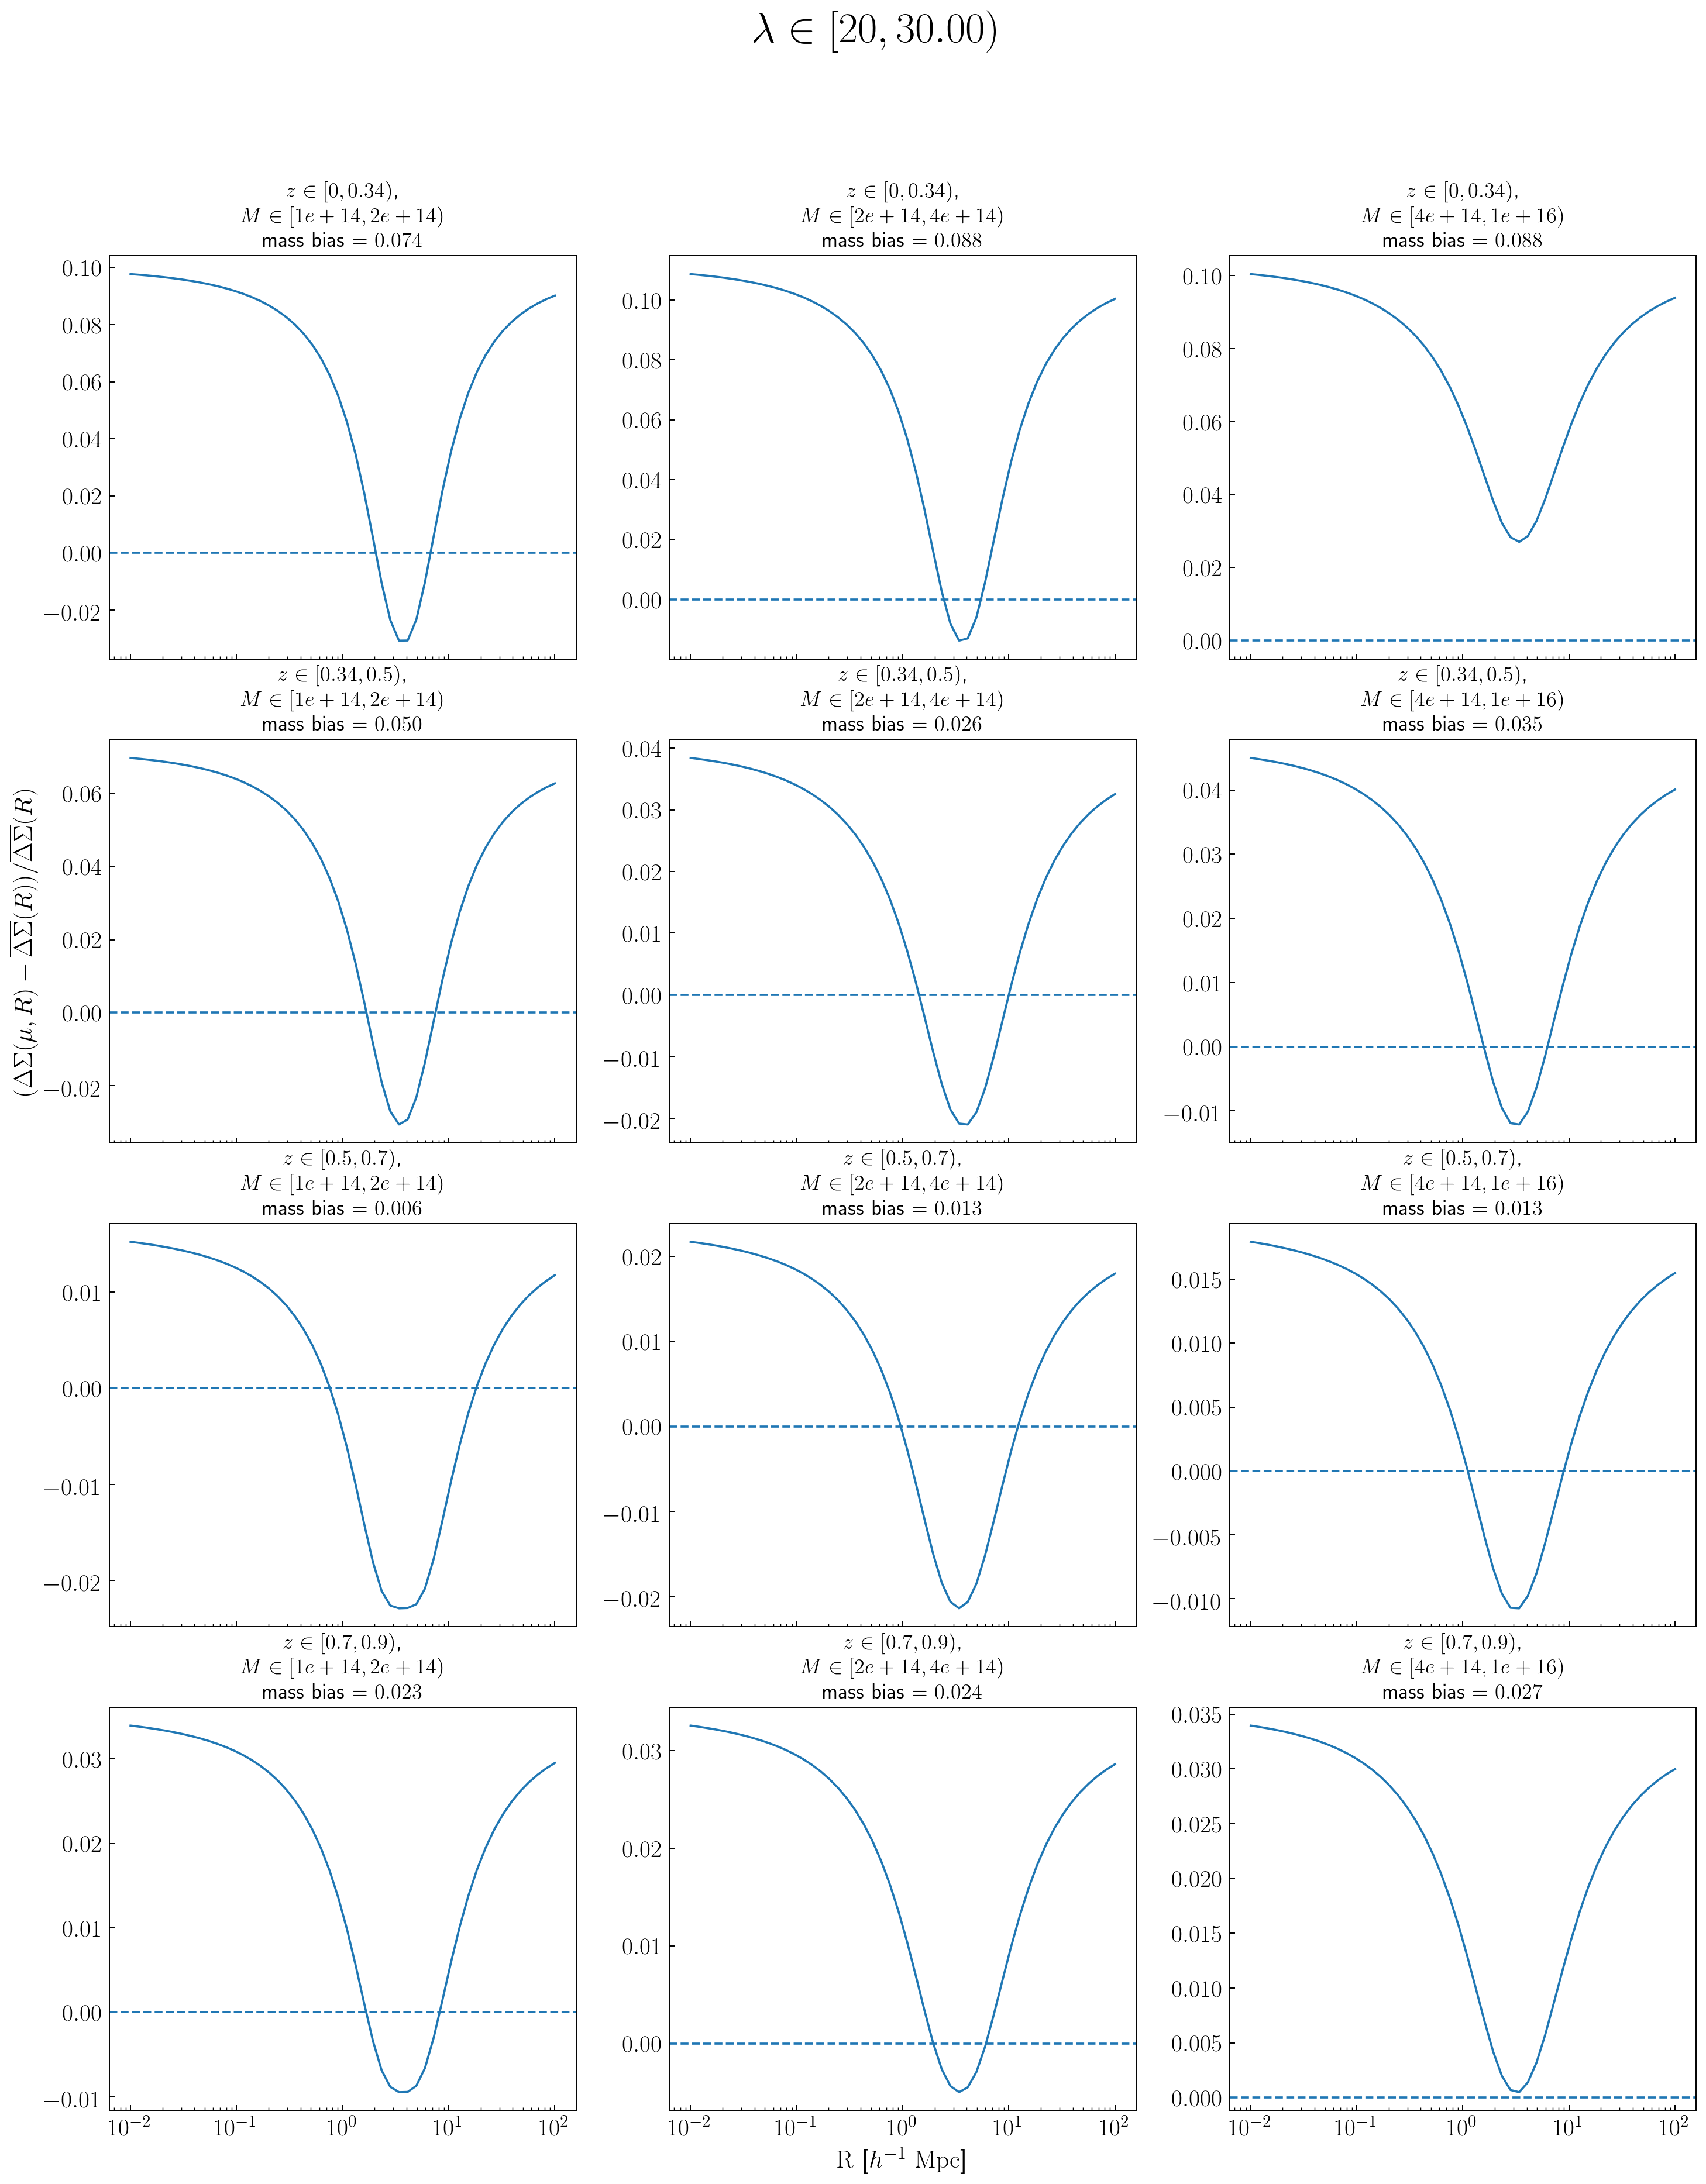

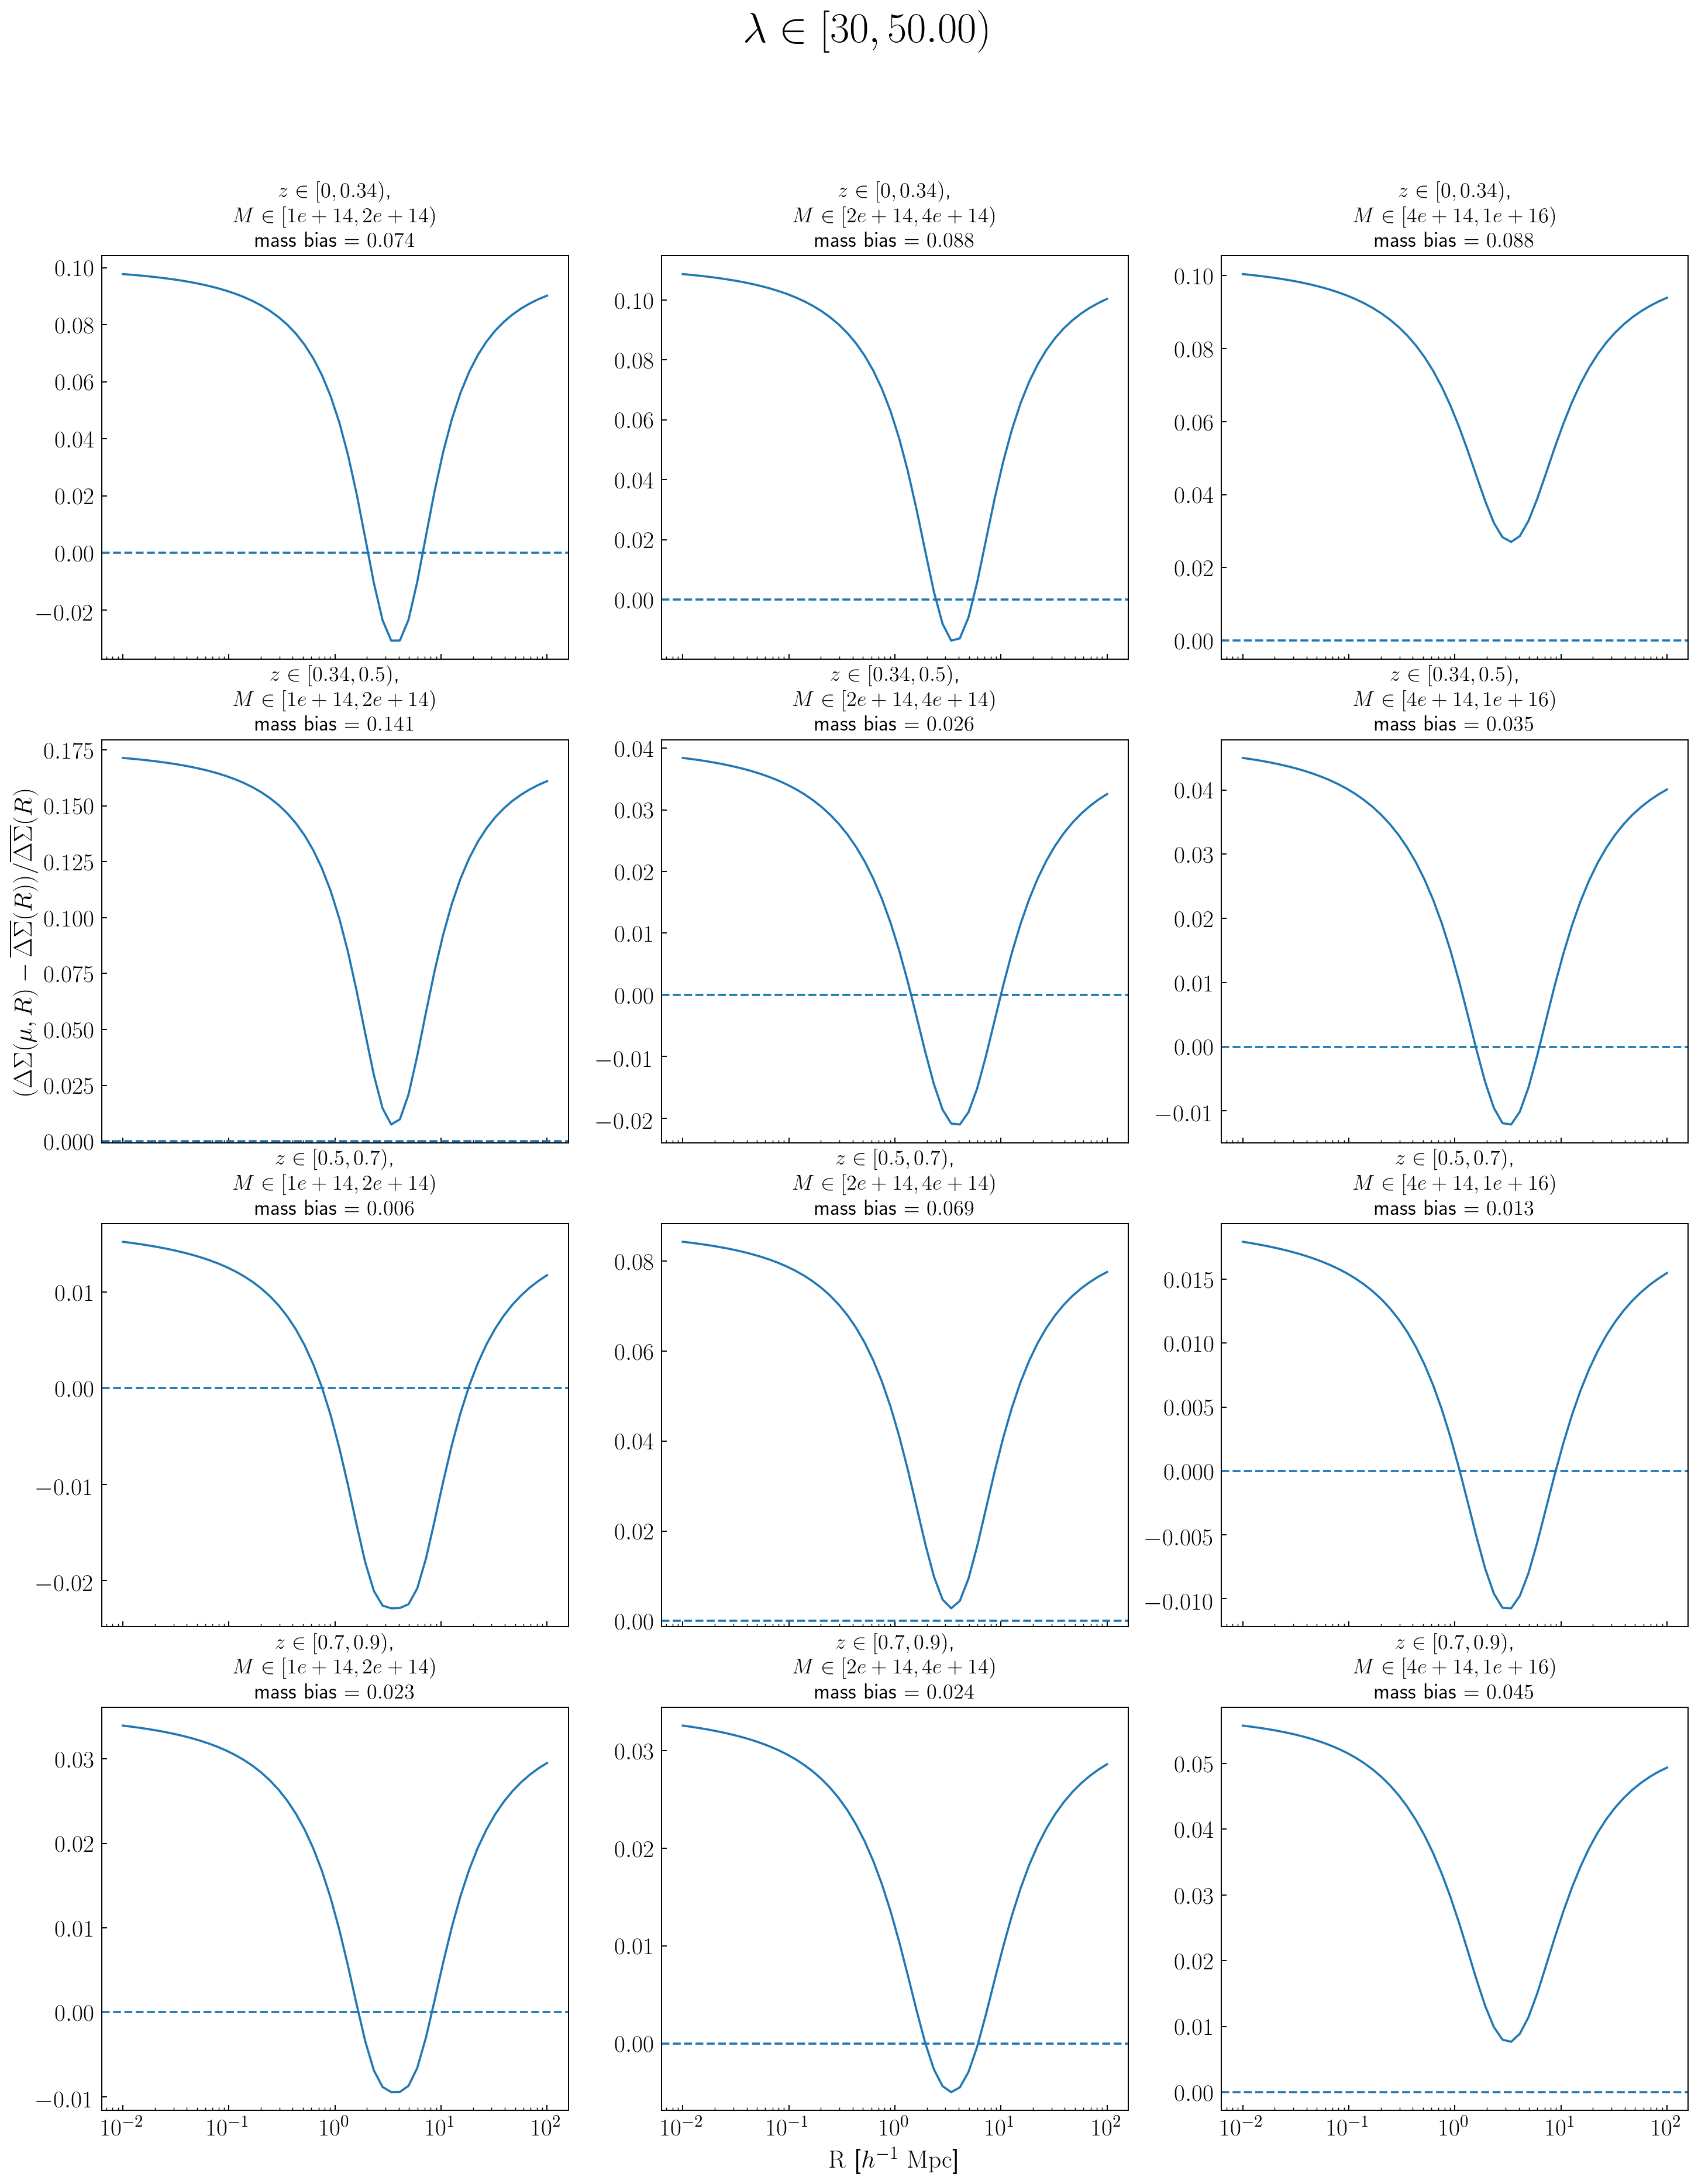

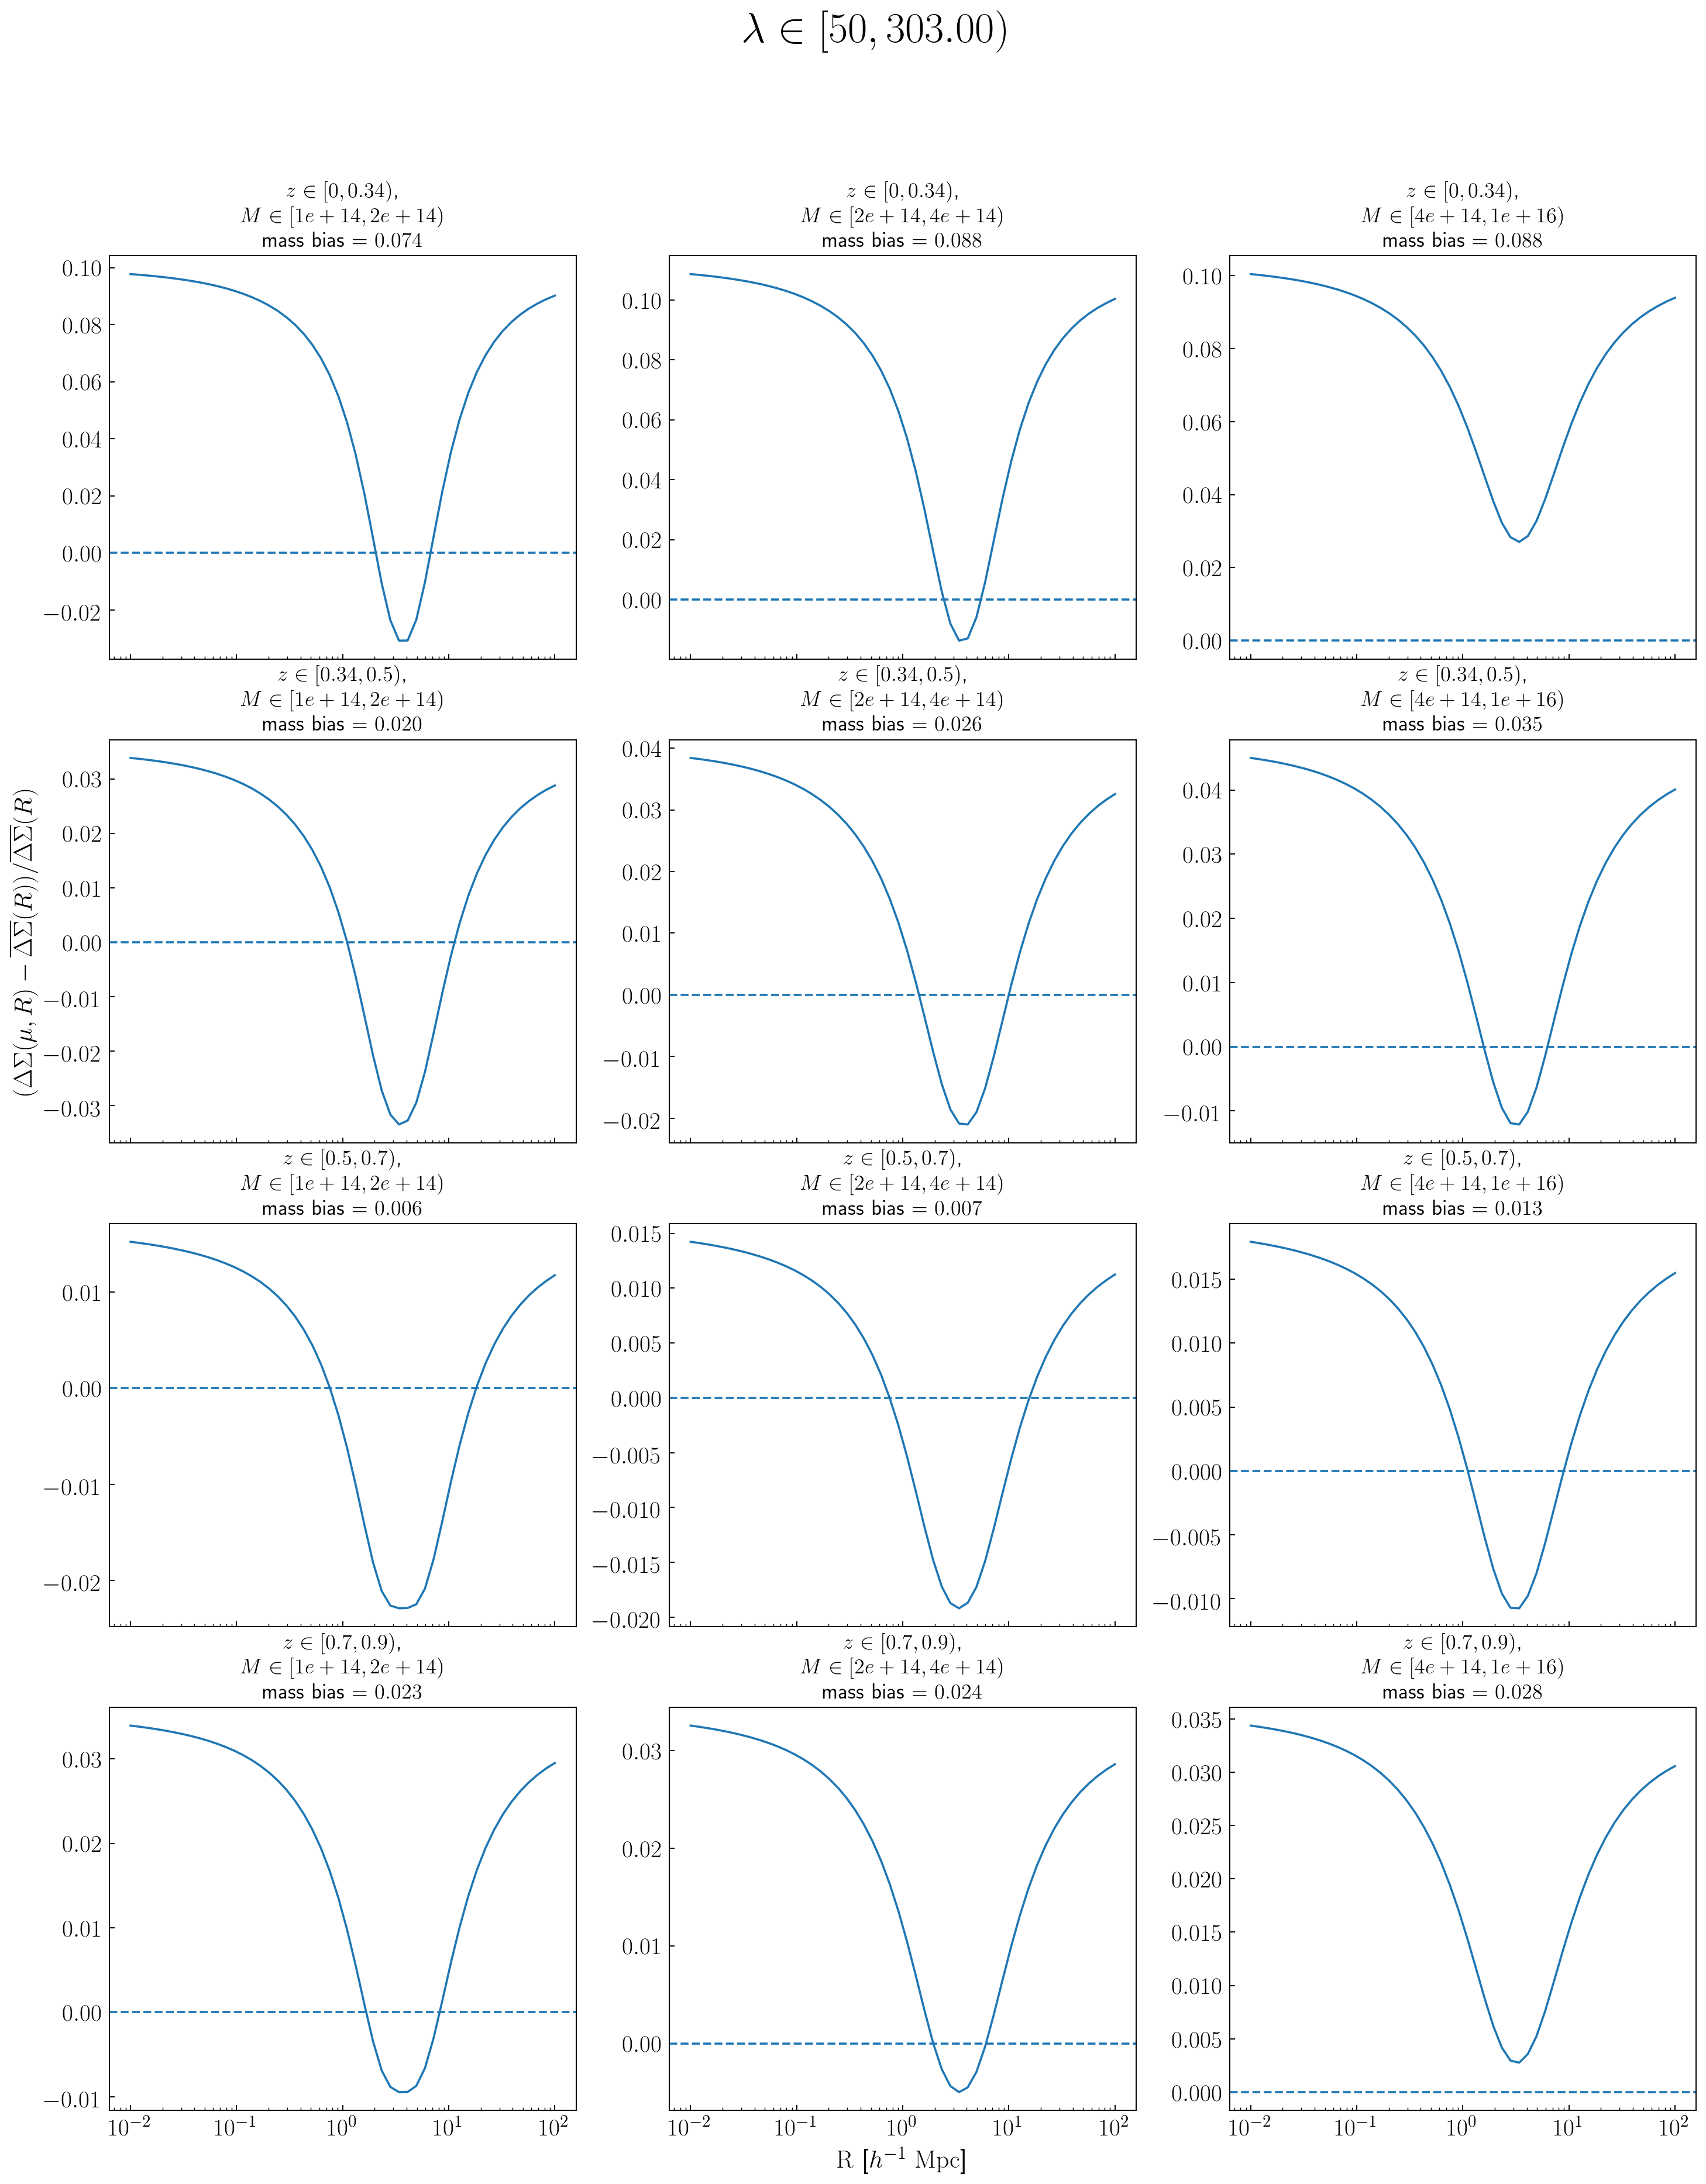

In [100]:
#Plot all and see what the difference is. Are all above 0.0 or any below 0.0. Can we disregard any based on noise?
for i in range(len(lmda_bins)):
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,24), sharex='all')
    fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[i][0],lmda_bins[i][1]), fontsize=30)
    for j, z_cur in enumerate(np.asarray(z_bins)[:,0]):
           #print "\nredshift range is [{0:.2g}, {1:.2g})".format(z_min[p,0], z_max[p,0])

        for k, m_cur in enumerate(np.asarray(m_bins)[:,0]):
            #print "mass range is [{0:.2g}, {1:.2g})".format(m_min[0,q], m_max[0,q])
            mass_bias = 0.
            for p in range(2): #j to conform with notation on notes
                mass_bias += fisher_inv[j,k][0,p] * np.linalg.multi_dot([DS_stacked_fracdiff_rp15[i,j,k], cov_inv[j,k], deriv_vector[p,j,k]])
                mass_bias = float(mass_bias)

            ax[j,k].plot(r_fracdiff, DS_stacked_fracdiff[i,j,k]) #Not the downsampled fracfiff
            ax[j,k].tick_params(axis='both', which='major', labelsize=17)
            ax[j,k].set_title('$z \in [{0:.2g}, {1:.2g})$, \n $M \in [{2:.2g}, {3:.2g})$ \n mass bias = ${4:.3f}$'\
                              .format(z_bins[j][0], z_bins[j][1], m_bins[k][0], m_bins[k][1], mass_bias), fontsize=15)
            ax[j,k].axhline(0.0, linestyle='--')

            
    ax[1,0].set_xscale('log'); #axs[1].set_yscale('log')
    ax[1,0].set_ylabel(r"$\big(\Delta\Sigma(\mu, R)-\overline{\Delta\Sigma}(R)\big)/\overline{\Delta\Sigma}(R)$", fontsize=18)
    ax[3,1].set_xlabel(r"\textrm{R} [$h^{-1}~$\textrm{Mpc}]"  , fontsize=18)
    plt.show()
#ax[0,0].legend(loc='upper left', fontsize=19)


### Marginalizing over different bins
(4,3) for redshift and mass
Ingredients include:
* P(M,z)
* $\delta$ DS(M,z) 
* Fisher matrix for each M,z
* dDS_c_bin[i,j] (4,3) 

In [112]:
mass_bias_lmda_binned = np.asarray([0.0 for i in range(3)]) #for the three lambda bins

for i, lmda_bin in enumerate(lmda_bins):
    for j, z_bin in enumerate(z_bins):
        for k, m_bin in enumerate(m_bins):
            
            prob_bin = prob_binned[i,j,k]
            mass_bias_bin = 0.0
            for p in range(2): #j to conform with notation on notes
                mass_bias_bin += fisher_inv[j,k][0,p] * \
                    np.linalg.multi_dot([DS_stacked_fracdiff_rp15[i,j,k], cov_inv[j,k], deriv_vector[p,j,k]])
                    
            mass_bias_lmda_binned[i] += prob_bin*mass_bias_bin
print mass_bias_lmda_binned

[0.03328002 0.05226413 0.01788517]


### Plot the global richness-binned plots. 

In [113]:
DS_stacked_fracdiff_lmdabinned = np.zeros((len(lmda_bins), r_num))
print np.shape(DS_stacked_fracdiff_lmdabinned)
for i, lmda_bin in enumerate(lmda_bins):
    for j, z_bin in enumerate(z_bins):
        for k, m_bin in enumerate(m_bins):
            
            prob_bin = prob_binned[i,j,k]
            DS_stacked_fracdiff_lmdabinned[i] += prob_bin*DS_stacked_fracdiff[i,j,k]                    

(3, 50)


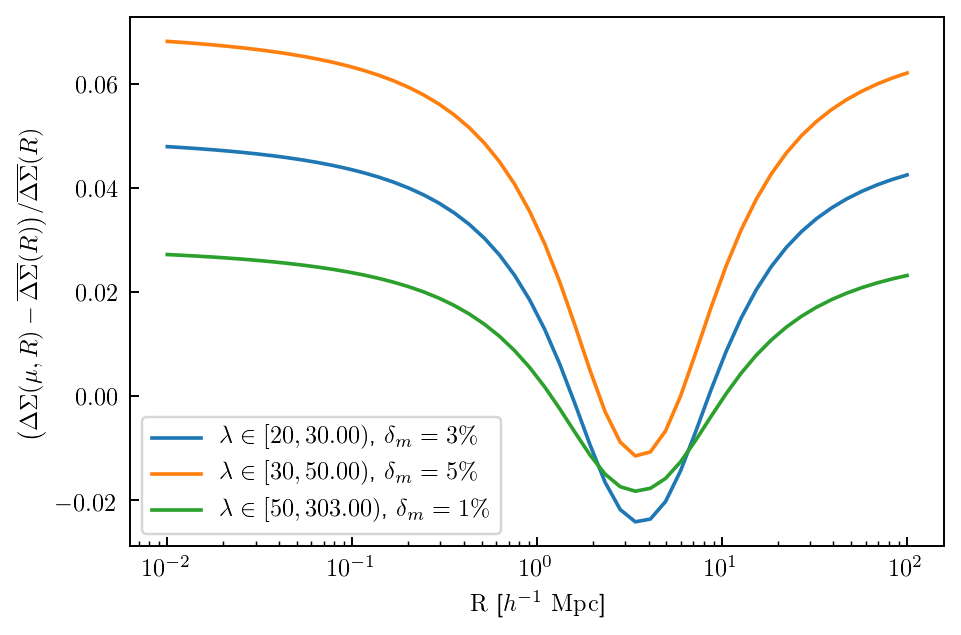

In [114]:
for i in range(3):
    plt.plot(r_fracdiff, DS_stacked_fracdiff_lmdabinned[i], label=r"$\lambda \in [{:.2g},{:.2f})$, $\delta_m={:d}\%$"\
             .format(lmda_bins[i][0],lmda_bins[i][1], int(mass_bias_lmda_binned[i]*100)))

plt.ylabel(r"$\big(\Delta\Sigma(\mu, R)-\overline{\Delta\Sigma}(R)\big)/\overline{\Delta\Sigma}(R)$", fontsize=10)
plt.xlabel(r"\textrm{R} [$h^{-1}~$\textrm{Mpc}]"  , fontsize=10)    
plt.xscale('log')
plt.legend()
plt.show()